## Here, I rapidly discuss and motivate some possible improvements in notation and plots

### Index:

- Notation
- (usual coding stuff you can skip)
- SIMULATION 1F
- SIMULATION 1W
- SIMULATION 2: station affinity
- SIMULATION 3A
- SIMULATION 3B

# Notation

I think that using letter "d" for "distal" and letter "p" for "proximal" in the symbols for kinetic constants will be better, as in the following scheme.
<div>
<img src="images/scheme_newnotation.png" width="800"/>
</div>

For example, in some of the plots we vary the parameters to make the proximal fueling reaction faster than the distal. Always calling "hindered" the proximal fueling constant may then result a bit misleading, which does not happen with the notation above. I also think that this notation helps in simplyfing the description of the system.

### Libraries, modules and physical constants

In the following two blocks I load what is needed to run the code and set the values of the physical constants.

In [1]:
%matplotlib inline 
#to generate figures directly in the notebook

# Libraries and Modules
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rcParams['text.usetex'] = True#
mpl.rcParams['text.latex.unicode'] = True#
import numpy as np
from numpy import *
from scipy.integrate import odeint
from scipy.optimize import *

print(mpl.__version__) #check of the matplotlib version

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


3.0.2


In [2]:
# Parameters and physical constants

h      = 6.62607004e-34   # [J*s]
kb     = 1.38064852e-23   # [J/K]
c      = 299792458        # [m/s]
Na     = 6.02214086e23    # [mol-1]
R      = kb*Na            # 8.314459865590527 [J/(mol*K)]
T      = 293              # [K]
    
C_kJ   = 4184 # 1kCal = 4184 J

print(R*T) #check


2436.1367406180243


In [3]:
# First order rate constants [s-1]

yc = 10 
gf = 10 
gc = 10
yf = 10

wm = 0.000008 #updated wrt version 1 
um = 0.000008 #updated wrt version 1 
fm = 0.0000001

# Second order rate constants [(s*M)-1]

fp = 0.008 
hp = 0.002

wp = 0.000001

# Rate constants set by thermodynamic constraints
hm = sqrt((hp*fm*yf*hp*fm*gf)/(fp*gc*fp*yc))
up = sqrt((um*yc*wp*um*gc*wp)/(gf*wm*yf*wm))


print('yc   ', yc)
print('gf   ', gf)
print('gc   ', gc)
print('yf   ', yf)
print('fp   ', fp)
print('hp   ', hp)
print('wm   ', wm)
print('um   ', um)
print('fm   ', fm)
print('hm   ', hm)
print('wp   ', wp)
print('up   ', up)

#Chemical potentials differencies:

DGT = -R*T*log(yc/gf) #Std Chem Pot DD - DH
DGT = -R*T*log(gc/yf) #Std Chem Pot HH - HD

muFmuW = R*T*log((fp*wm)/(fm*wp)) #Std chemical potential gradient F-W

DGf = -R*T*log(fp/fm)
DGh = -R*T*log(hp/hm)
DGw = -R*T*log(wp/wm)

print('DGT   ',DGT) 
print('muFmuW    ', muFmuW)

### "standard" kinetic asymmetry
Kr_std  = ((hm+um)**2*yc*(fp+wp)**2*gc/((hp+up)**2*gf*(fm+wm)**2*yf))
print('Kr_std   ', Kr_std)

###  
#print(DGf,DGh,DGw)

### condizione su F per equilibrio

#W0 = 0.000001
#Feq = W0*exp(-muFmuW/(R*T))
#print(Feq)




yc    10
gf    10
gc    10
yf    10
fp    0.008
hp    0.002
wm    8e-06
um    8e-06
fm    1e-07
hm    2.5e-08
wp    1e-06
up    1e-06
DGT    -0.0
muFmuW     32569.25645307593
Kr_std    15.693304732011246


In [4]:
def SS_solution(ss,yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM):
    """
    This function takes as input kinetic constants, chemostatted concentrations of F and W, and conserved
    quantity LM. The output is a 6-d array named "ss" containing the stationary state concentrations of the
    internal species.
    """
    
    PH  = ss[0]
    PD  = ss[1]
    DH  = ss[2]
    HD  = ss[3]
    DD  = ss[4]
    HH  = ss[5]
              
    #solo 3 delle 4 equazioni allo stato stazionario sono indipendenti, perché ho una legge di conservazione
              
    H = empty((6))
    H[0] = -(hm+um+fm+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*HH  #PH
    H[1] = -(hm+um+fm+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD #PD
    H[2] = -(hp*F0+up*W0+yc)*DH + (hm+um)*PH + gf*DD  #DH
    H[3] = -(hp*F0+up*W0+gc)*HD + (hm+um)*PD + yf*HH  #HD
    H[4] = -(fp*F0+wp*W0+gf)*DD + (fm+wm)*PD + yc*DH  #DD
    H[5] = (PH + PD + DH + HD + DD + HH) - LM #conservation of motor
    return H

## The routine for equilibrium is not strictly needed at the moment
#def EQ_solution(eq,sp,sm,fp,fm,wp,wm,hp,hm,W0,LM):
#    """
#    This function takes as input kinetic constants, chemostatted concentration of W (taken as reference to define
#    the equilibrium distribution), and conserved quantity LM. The output is a 7-d array named "eq" containing the 
#    equilibrium concentrations of the internal species and F given [W] = W0.
#    """
#
#    EPH  = eq[0]
#    EPD  = eq[1]
#    EDH  = eq[2]
#    EHD  = eq[3]
#    EDD  = eq[4]
#    EHH  = eq[5]
#    EF   = eq[6]
#
#    G = empty((7))
#    G[0] =  sp*EDH - sm*EDD #switching 
#    G[1] =  sm*EHD - sp*EHH  #switching
#    G[2] =  fm*EPD - fp*EF*EDD  #fueling
#    G[3] =  wm*EPD - wp*W0*EDD  #wasting
#    G[4] =  fm*EPH - fp*EF*EHH #fueling
#    G[5] =  wm*EPH - wp*W0*EHH #wasting
#    G[6] =  (EPH + EPD + EDH + EHD + EDD + EHH) - LM #conservation of motor
#    return G

def DY_solution(y, t, params):
    """
    This function takes as input kinetic constants, chemostatted concentration of F and W, and conserved quantity 
    LM. The output is the list of rate equations (eq. (1) in the notes) of the kind dy[i]/dt = derivs[i] to
    solve numerically with scipy odeint in order to get the time evolution of concentrations from a certain 
    initial condition up tu a certain time. The conservation of the total amount of motor is "built-in" in writing
    HH as LM minus the sum of all other concentrations.
    """
    PH,PD,DH,HD,DD = y
    yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM = params
    derivs = [-(hm+um+fm+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*(LM - PH -PD -DH - HD -DD), #PH
              -(hm+um+fm+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD, #PD
              -(hp*F0+up*W0+yc)*DH + (hm+um)*PH + gf*DD, #DH
              -(hp*F0+up*W0+gc)*HD + (hm+um)*PD + yf*(LM - PH -PD -DH - HD -DD), #HD
              -(fp*F0+wp*W0+gf)*DD + (fm+wm)*PD + yc*DH] #DD
    return derivs

In [5]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
                self.midpoint = midpoint
                colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
                # I'm ignoring masked values and all kinds of edge cases to make a
                # simple example...
                x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
                return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


In [6]:
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 

F0 = 0.03; W0 = 0.00001  ; LM = 0.01; 
ss = fsolve(SS_solution,ssGuess,args=(yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM))

#affinity/force
aff = R*T*log((fp*wm)/(fm*wp)) + R*T*(log(F0) - log(W0))

#currents
jss = yc*ss[2] - gf*ss[4]
ifuel = F0*(fp*ss[4] + fp*ss[5] + hp*ss[2] + hp*ss[3]) - (fm+hm)*(ss[1] + ss[0])

#work
wch = ifuel*aff

#info
imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))

#energy ratchet
er = jss*log((yc*gc)/(gf*yf))

#efficiency
ncd = R*T*(imh+er)/wch 
      
print(jss)
print(ncd)

2.1670317925520655e-08
1.2533159279586223e-07


# SIMULATION 1F

As Ben noticed, the "old" version of this plot (figure 2A in his report) is non-symmetrical with respect to horizontal reflection. This is normal and due to the choice of plotting the kinetic gating $\frac{k_{+\mathrm{F}}}{k^\mathrm{h}_{+\mathrm{F}}}$ against $k_{+\mathrm{F}}$, which "has a direction" and thus breaks the symmetry of the plot.

We can avoid such bias with a very simple solution: abstaining ourselves from arbitrary picking one of the constants and plottig on the x-axix their sum. We thus have:
- symmetric plots showing that the motor can be perfectly reversed by reversing the kinetig gating
- same information as before (each point uniquely identifies single values for $k_{+\mathrm{F}}$ and $k^\mathrm{h}_{+\mathrm{F}}$)
- the quantity $k_{+\mathrm{F}} + k^\mathrm{h}_{+\mathrm{F}}$ still has a quite intuitive physical meaning which does not compromise the legibility of the plot


As usual, the blue dotted lines show experimental conditions. The white solid line indicates the set of point at zero current.

### Also note that:
- in all the plots, the colormap for the current is centered in 0 as we decided
- I adopted a new colormap for the efficiency plots

In [150]:
#definition of lists (where to collect data)
SLP = []; Ratio = []; FPAVERAGE = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; IFJRATIO = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
fp_min = 1e-3; fp_max = 1e4#1e3; 
rt_min = 1e-2; rt_max = 1e2;
num = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; IFJ =[]; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(fp_min,fp_max,num):
        for r in np.geomspace(rt_min,rt_max,num):
            
            #check for Ben
            flp = r*somma/(r+1)
            
            ylc = yc 
            glc = gc
            glf = gf
            ylf = yf
            flm = fm*(flp/fp) #assuming that the modification only affects the barriers 
            wlm = wm 
            wlp = wp
            ulm = um 
            hlp = flp/r 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            
            
    
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            IFJ.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
       
    IFJRATIO.append(np.array(IFJ))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))

### Effect on the current $J_\mathrm{ss}$

Since no energy ratchet is introduced here, $J_\mathrm{ss} = 0$ is realized when $\frac{k_{+\mathrm{F}}}{k^\mathrm{h}_{+\mathrm{F}}} = 1$. 

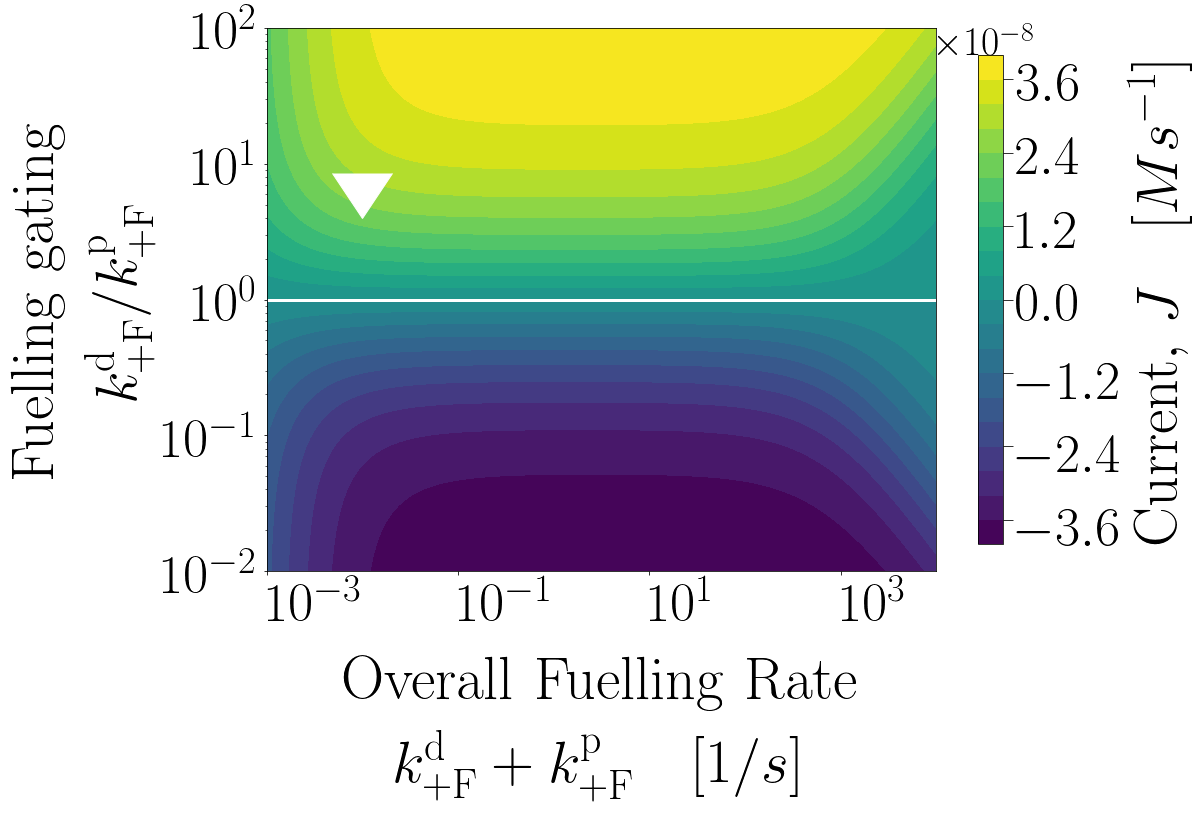

In [151]:
x=np.unique(np.geomspace(fp_min,fp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

labs = 60 #labelsize
digs = 55 #numbersize


fuelingJ, axF = plt.subplots(1, figsize=(15,10), sharex=True)
#fuelingJ, axF = plt.subplots(1, figsize=(2,1.3), sharex=True)


im = axF.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
axF.set_xlabel('$\mathrm{Overall \, \, Fuelling \, \, Rate}$ \n $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}} \quad [1/s]$',linespacing=1.5,size=labs)
axF.set_ylabel('$\mathrm{Fuelling \, \, gating}$ \n ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=labs)
axF.tick_params(axis='x', labelsize=digs)
axF.set_xticklabels(x, ha='left')
axF.tick_params(axis='y', labelsize=digs)
axF.xaxis.set_label_coords(0.5,-0.15)
axF.yaxis.set_label_coords(-0.15,0.5)

#axF.axhline(y=fp/hp, c='0.5', linestyle=':',linewidth=3.0)
#axF.axvline(x=fp+hp, c='0.5', linestyle=':',linewidth=3.0)
axF.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0 ,colors='w')
axF.set_xscale('log')
axF.set_yscale('log')
#axF.set_title('$[\mathrm{F}]$ = %s M'%FUEL, size=30, pad=10) 

cbar = fuelingJ.colorbar(im, shrink=0.9)
cbar.ax.tick_params(labelsize=digs, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.ax.yaxis.get_offset_text().set_position((2.5,1))
#cbar.ax.yaxis.get_offset_text().set(size=35)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=labs, labelpad= 5)

plt.plot(fp+hp,fp/hp, marker=7,markersize=labs,c='w')



# scientific notation offset: https://stackoverflow.com/questions/34039396/matplotlib-colorbar-scientific-notation-offset/34040292

#fuelingJ.savefig('images/presentation/1_ratcheting_principle_NORM+BOUND.png', dpi=300)
fuelingJ.savefig('images/plots4Elisabeth/1F_current.png', dpi=300, bbox_inches='tight')

plt.show()

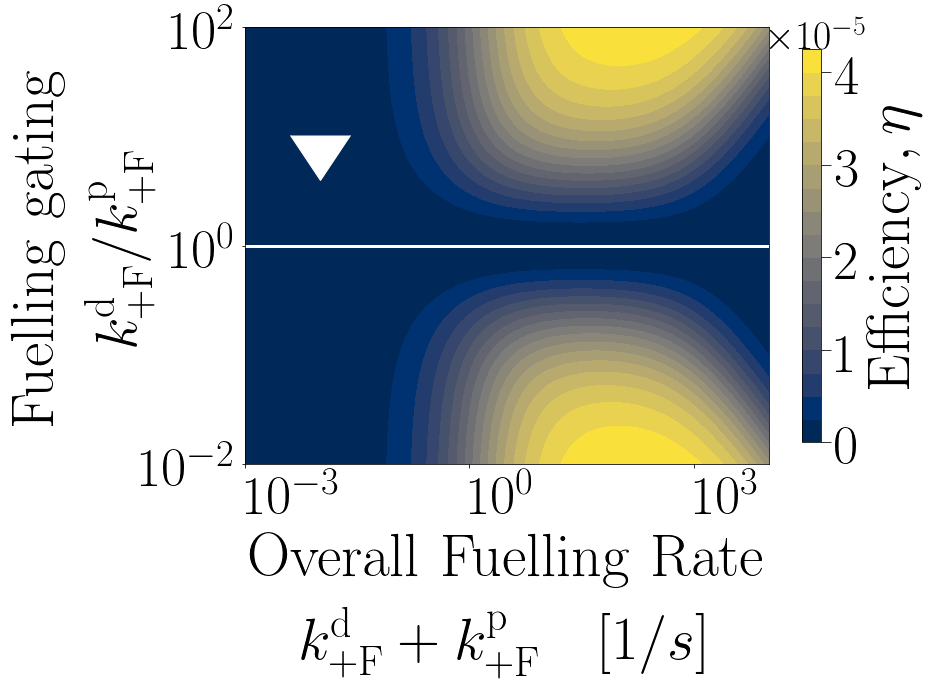

In [152]:
x=np.unique(np.geomspace(fp_min,fp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))


labs = 60 #labelsize
digs = 55 #numbersize


fuelingEff, axFE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axFE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
#trick to get the ticks and then customize the colorbar
tmpcbar = fuelingEff.colorbar(im)
tt = tmpcbar.get_ticks()
tmpcbar.remove()
cbar = fuelingEff.colorbar(im, ax=axFE, shrink=0.9, ticks=[tt[i] for i in range(0,10,2)])
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.tick_params(labelsize=digs, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.ax.yaxis.get_offset_text().set_position((3.5,1))
cbar.set_label("$\mathrm{Efficiency}, \eta$", size=labs, labelpad= 5)


axFE.set_xticklabels(x, ha='left')
axFE.set_xscale('log')
axFE.set_yscale('log')
axFE.set_xlabel('$\mathrm{Overall \, \, Fuelling \, \, Rate}$ \n $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}} \quad [1/s]$',linespacing=1.5,size=labs)
axFE.set_ylabel('$\mathrm{Fuelling \, \, gating}$ \n ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=labs)
#axFE.set_title('$[\mathrm{F]} =$ %s M'%FUEL,size=30, pad=10)
axFE.tick_params(axis='x', labelsize=digs)
axFE.tick_params(axis='y', labelsize=digs)
axFE.xaxis.set_label_coords(0.5,-0.15)
axFE.yaxis.set_label_coords(-0.15,0.5)
axFE.axhline(y=1, c='w', linestyle='-',linewidth=3.0) 
#axFE.axhline(y=fp/hp, c='0.5', linestyle=':',linewidth=3.0) 
#axFE.axvline(x=fp+hp, c='0.5', linestyle=':',linewidth=3.0)

#plt.text(0.0015, 1.5, '$T\dot{\mathcal{I}}>0$',size=30, color='w')
#plt.text(0.0015, 0.5, '$T\dot{\mathcal{I}}<0$',size=30, color='w')
plt.plot(fp+hp,fp/hp, marker=7,markersize=labs,c='w')

plt.tight_layout()

#fuelingEff.savefig('images/presentation/1_ratcheting_efficiency.png', dpi=300)
fuelingEff.savefig('images/plots4Elisabeth/1F_efficiency.png', dpi=300, bbox_inches='tight')


plt.show()

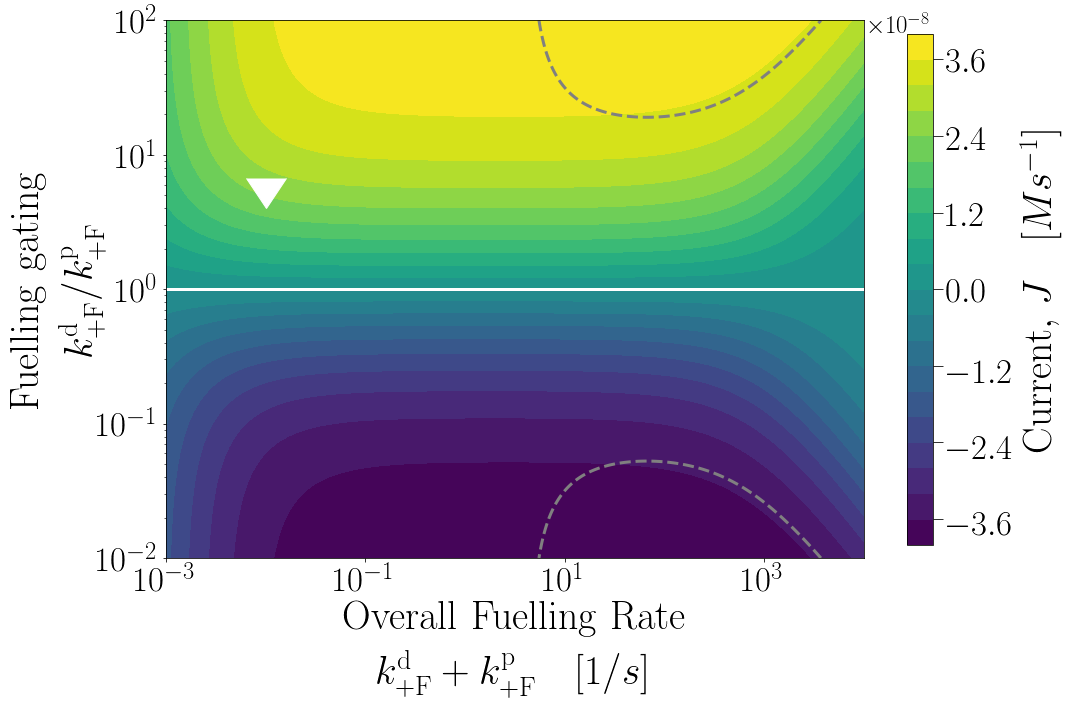

In [50]:
x=np.unique(np.geomspace(fp_min,fp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0


fuelingJ, axF = plt.subplots(1, figsize=(15,10), sharex=True)


im = axF.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
axF.set_xlabel('$\mathrm{Overall \, \, Fuelling \, \, Rate}$ \n $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}} \quad [1/s]$',linespacing=1.5,size=40)
axF.set_ylabel('$\mathrm{Fuelling \, \, gating}$ \n ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=40)
axF.tick_params(axis='x', labelsize=35)
axF.tick_params(axis='y', labelsize=35)
axF.xaxis.set_label_coords(0.5,-0.075)
axF.yaxis.set_label_coords(-0.075,0.5)

#axF.axhline(y=fp/hp, c='0.5', linestyle=':',linewidth=3.0)
#axF.axvline(x=fp+hp, c='0.5', linestyle=':',linewidth=3.0)
axF.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0 ,colors='w')
axF.set_xscale('log')
axF.set_yscale('log')
#axF.set_title('$[\mathrm{F}]$ = %s M'%FUEL, size=30, pad=10) 

cbar = fuelingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=35, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=40, labelpad= 5)

plt.plot(fp+hp,fp/hp, marker=7,markersize=40,c='w')


plt.tight_layout()


# scientific notation offset: https://stackoverflow.com/questions/34039396/matplotlib-colorbar-scientific-notation-offset/34040292

#fuelingJ.savefig('images/presentation/1_ratcheting_principle_NORM+BOUND.png', dpi=300)
#fuelingJ.savefig('images/plots4Elisabeth/1F_current.png', dpi=300)

#test---
aaa = axF.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.000035],linewidths=3.0,linestyles='--' ,colors='gray')
#
#fmt = {}
#strs = ['$0.0004\%$', '$0.004\%$']
#for l, s in zip(aaa.levels, strs):
#    fmt[l] = s
##
### Label every other level using strings
#axF.clabel(aaa, aaa.levels, inline=True, fmt=fmt, fontsize=25)

fuelingJ.savefig('images/plots4Elisabeth/1F_ALL.png', dpi=300,bbox_inches='tight')

plt.show()

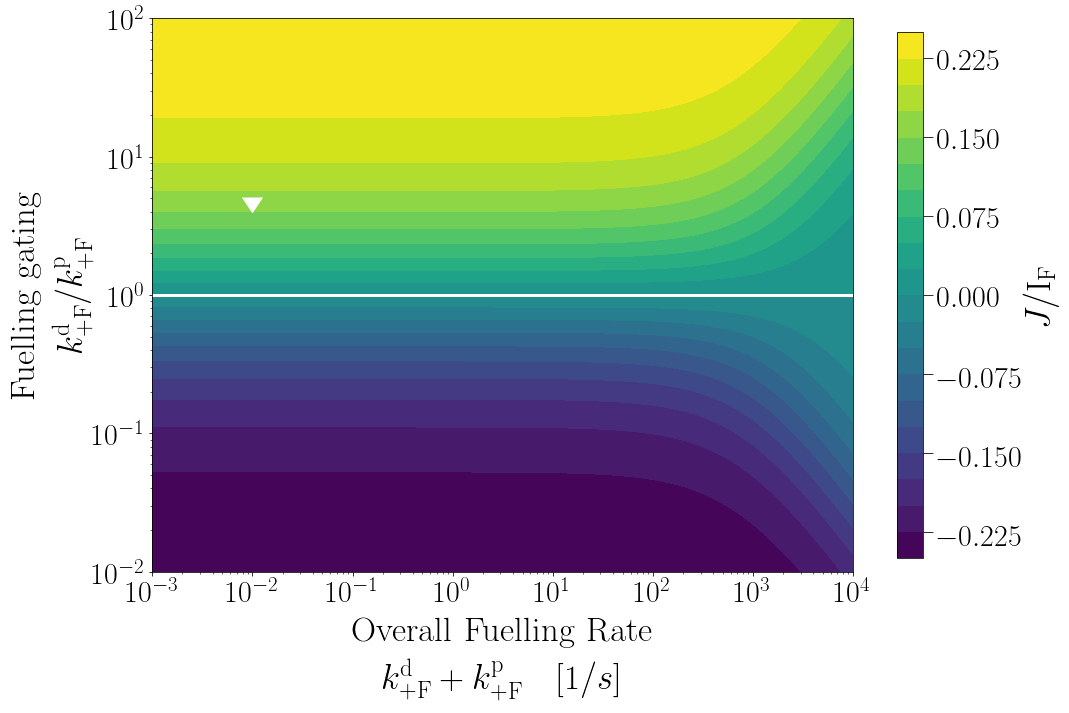

In [19]:
x=np.unique(np.geomspace(fp_min,fp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(IFJRATIO[0])
elev_max=max(IFJRATIO[0])
mid_val=0.0


IFJplot, axF = plt.subplots(1, figsize=(15,10), sharex=True)


im = axF.contourf(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
axF.set_xlabel('$\mathrm{Overall \, \, Fuelling \, \, Rate}$ \n $k^\mathrm{d}_{+\mathrm{F}}+k^\mathrm{p}_{+\mathrm{F}} \quad [1/s]$',linespacing=1.5,size=35)
axF.set_ylabel('$\mathrm{Fuelling \, \, gating}$ \n ${k^\mathrm{d}_{+\mathrm{F}}}/{k^\mathrm{p}_{+\mathrm{F}}}$',linespacing=1.5,size=35)
axF.tick_params(axis='x', labelsize=30)
axF.tick_params(axis='y', labelsize=30)
axF.xaxis.set_label_coords(0.5,-0.075)
axF.yaxis.set_label_coords(-0.075,0.5)

#axF.axhline(y=fp/hp, c='0.5', linestyle=':',linewidth=3.0)
#axF.axvline(x=fp+hp, c='0.5', linestyle=':',linewidth=3.0)
axF.contour(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0 ,colors='w')
axF.set_xscale('log')
axF.set_yscale('log')
#axF.set_title('$[\mathrm{F}]$ = %s M'%FUEL, size=30, pad=10) 

cbar = IFJplot.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$ J/\mathrm{I_F}$", size=35, labelpad= 5)

plt.plot(fp+hp,fp/hp, marker=7,markersize=20,c='w')


plt.tight_layout()


# scientific notation offset: https://stackoverflow.com/questions/34039396/matplotlib-colorbar-scientific-notation-offset/34040292

#fuelingJ.savefig('images/presentation/1_ratcheting_principle_NORM+BOUND.png', dpi=300)
#fuelingJ.savefig('images/plots4Elisabeth/1F_current.png', dpi=300)
IFJplot.savefig('Ben_ados/images/Fgating_JoverIF.png', dpi=150)

plt.show()

# SIMULATION 1W

Same logic as above

In [51]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; IFJRATIO = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
wm_min = 1e-6; wm_max = 1e1#1e-1; 
rt_min = 1e-3; rt_max = 1e3;
num = 100;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; IFJ = [];
    FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(wm_min,wm_max,num):
        for r in np.geomspace(rt_min,rt_max,num):
            
            wlm = r*somma/(r+1)
            
            ylc = yc 
            glc = gc
            glf = gf
            ylf = yf
            wlp = wp*(wlm/wm) #assuming that the modification only affects the barriers 
            flp = fp 
            flm = fm
            ulm = wlm/r 
            hlp = hp 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            IFJ.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
    
    IFJRATIO.append(np.array(IFJ))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))

### Effect on the current $J_\mathrm{ss}$

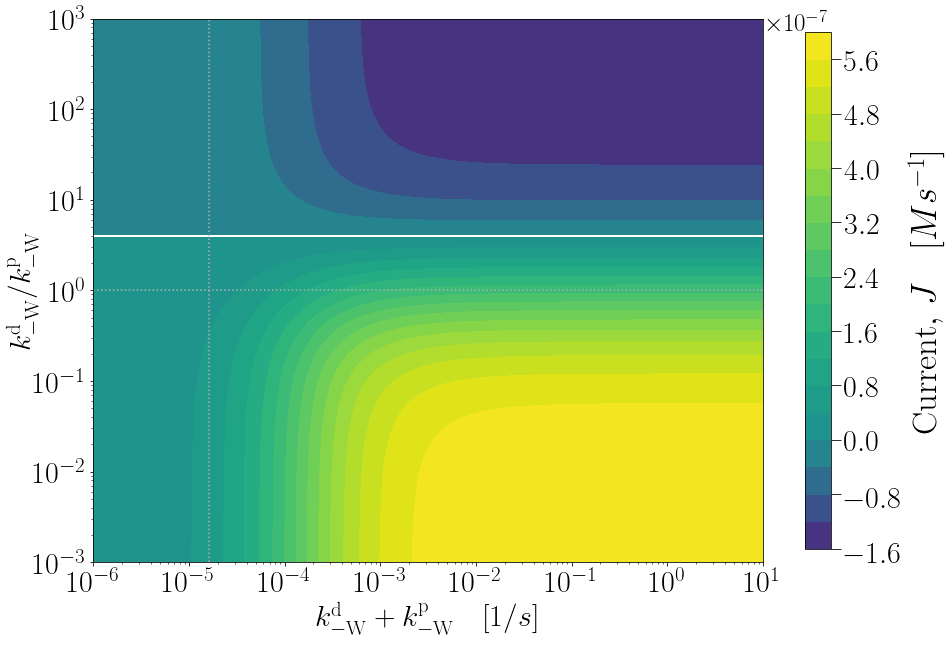

In [21]:
x=np.unique(np.geomspace(wm_min,wm_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

wastingJ, axW = plt.subplots(1, figsize=(15,10), sharex=True)

elev_min= -2e-7
elev_max= 6e-7
#elev_min= min(FUELINGJ[0])
#elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axW.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axW.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)

axW.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=2.0)
axW.set_xscale('log')
axW.set_yscale('log')
axW.set_xlabel('${k^\mathrm{d}_{-\mathrm{W}}} + {k^\mathrm{p}_{-\mathrm{W}}} \quad [1/s]$', size=30)
axW.set_ylabel('${k^\mathrm{d}_{-\mathrm{W}}}/{k^\mathrm{p}_{-\mathrm{W}}}$', size=30)
#axW.set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL, size=30, pad=10)
axW.tick_params(axis='x', labelsize=30)
axW.tick_params(axis='y', labelsize=30)
axW.xaxis.set_label_coords(0.5,-0.075)
axW.yaxis.set_label_coords(-0.075,0.5)
axW.axhline(y=wm/um, c='0.7', linestyle=':')
axW.axvline(x=wm+um, c='0.7', linestyle=':')


cbar = wastingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

wastingJ.savefig('images/plots4Elisabeth/1W_current.png', dpi=300)

plt.show()

### Effect on the efficiency

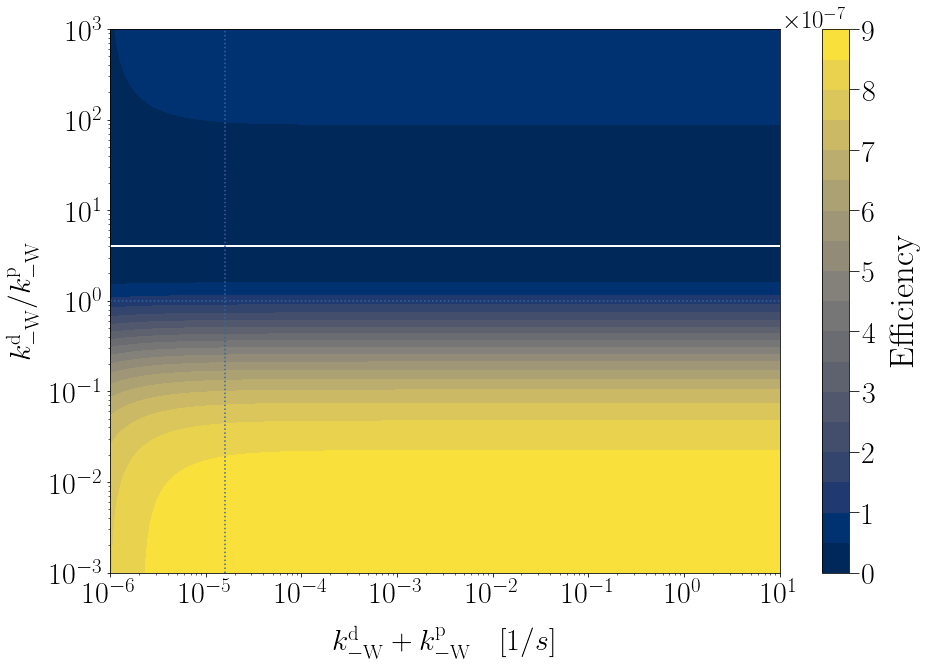

In [22]:
x=np.unique(np.geomspace(wm_min,wm_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

wastingEff, axWE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axWE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
cbar = wastingEff.colorbar(im, ax=axWE)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.ax.yaxis.set_offset_position('right')
cbar.set_label("$\mathrm{Efficiency}$", size=35, labelpad= 10)



axWE.set_xscale('log') 
axWE.set_yscale('log') 
axWE.set_xlabel('${k^\mathrm{d}_{-\mathrm{W}}} + {k^\mathrm{p}_{-\mathrm{W}}} \quad [1/s]$', size=30)
axWE.set_ylabel('${k^\mathrm{d}_{-\mathrm{W}}}/{k^\mathrm{p}_{-\mathrm{W}}}$', size=30) 
#axWE.set_title('$\eta_\mathrm{cd} \quad for \quad [\mathrm{F}] =  $%s M'%FUEL, size=30)
axWE.tick_params(axis='x', labelsize=30)
axWE.tick_params(axis='y', labelsize=30)
axWE.xaxis.set_label_coords(0.5,-0.1)
axWE.yaxis.set_label_coords(-0.1,0.5)
axWE.axhline(y=wm/um, c='#3465A4', linestyle=':')
axWE.axvline(x=wm+um, c='#3465A4', linestyle=':') 

axWE.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=2.0)

wastingEff.savefig('images/plots4Elisabeth/1W_efficiency.png', dpi=300)

plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


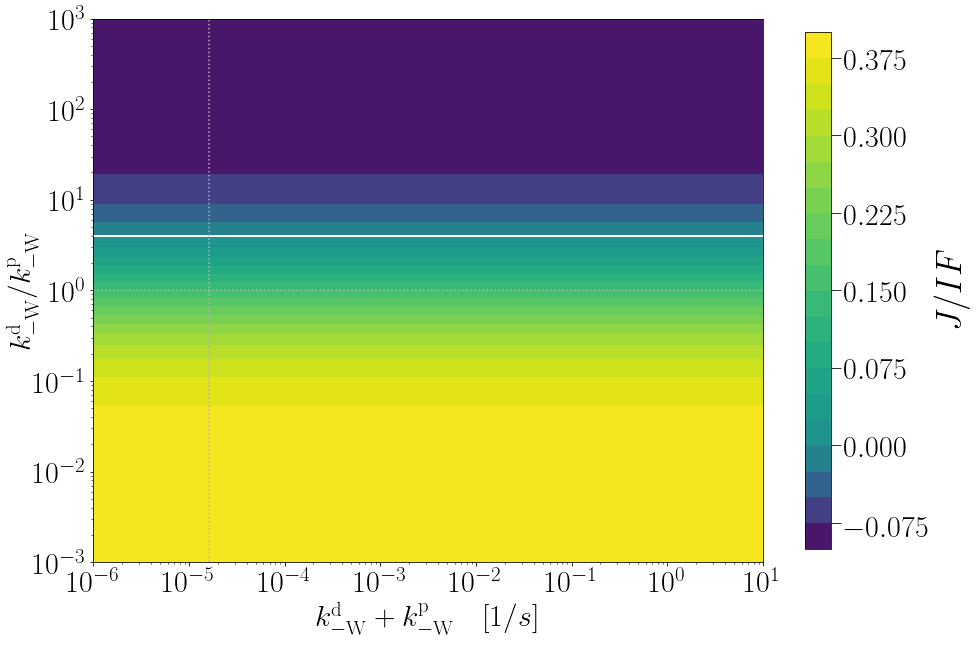

In [24]:
x=np.unique(np.geomspace(wm_min,wm_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

wastingJ, axW = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(IFJRATIO[0])
elev_max=max(IFJRATIO[0])
mid_val=0.0

im = axW.contourf(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axW.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)

axW.contour(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=2.0)
axW.set_xscale('log')
axW.set_yscale('log')
axW.set_xlabel('${k^\mathrm{d}_{-\mathrm{W}}} + {k^\mathrm{p}_{-\mathrm{W}}} \quad [1/s]$', size=30)
axW.set_ylabel('${k^\mathrm{d}_{-\mathrm{W}}}/{k^\mathrm{p}_{-\mathrm{W}}}$', size=30)
#axW.set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL, size=30, pad=10)
axW.tick_params(axis='x', labelsize=30)
axW.tick_params(axis='y', labelsize=30)
axW.xaxis.set_label_coords(0.5,-0.075)
axW.yaxis.set_label_coords(-0.075,0.5)
axW.axhline(y=wm/um, c='0.7', linestyle=':')
axW.axvline(x=wm+um, c='0.7', linestyle=':')


cbar = wastingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$ J/IF$", size=35, labelpad= 5)

#wastingJ.savefig('images/plots4Elisabeth/1W_current.png', dpi=300)

plt.show()

# SIMULATION 2: Station affinity

In [72]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; IFJRATIO = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 2e5; 
#rt_min = 1e-2; rt_max = 1e2;
rt_min = 1; rt_max = 1e5;

num = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
#for F0 in [0.003, 0.03, 0.3, 3]:
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; JIF = [] ; FUEL.append(F0) #lits to renew on each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num):
            
            #check for Ben
            ylc = r*somma/(r+1)
            
            ylf = ylc
            glf = ylc/r #sm defined accordingly o r and sp in the loop
            glc = glf
            wlm = wm 
            ulm = um 
            flm = fm 
            flp = fp 
            hlp = hp 
            wlp = wp
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #efficiency
            ncd = R*T*imh/wch
            Eff.append(ncd)
    
    IFJRATIO.append(np.array(JIF))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))


/home/emanuele/venv_research/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### Effect on the current $J_\mathrm{ss}$

TypeError: 'AxesSubplot' object does not support indexing

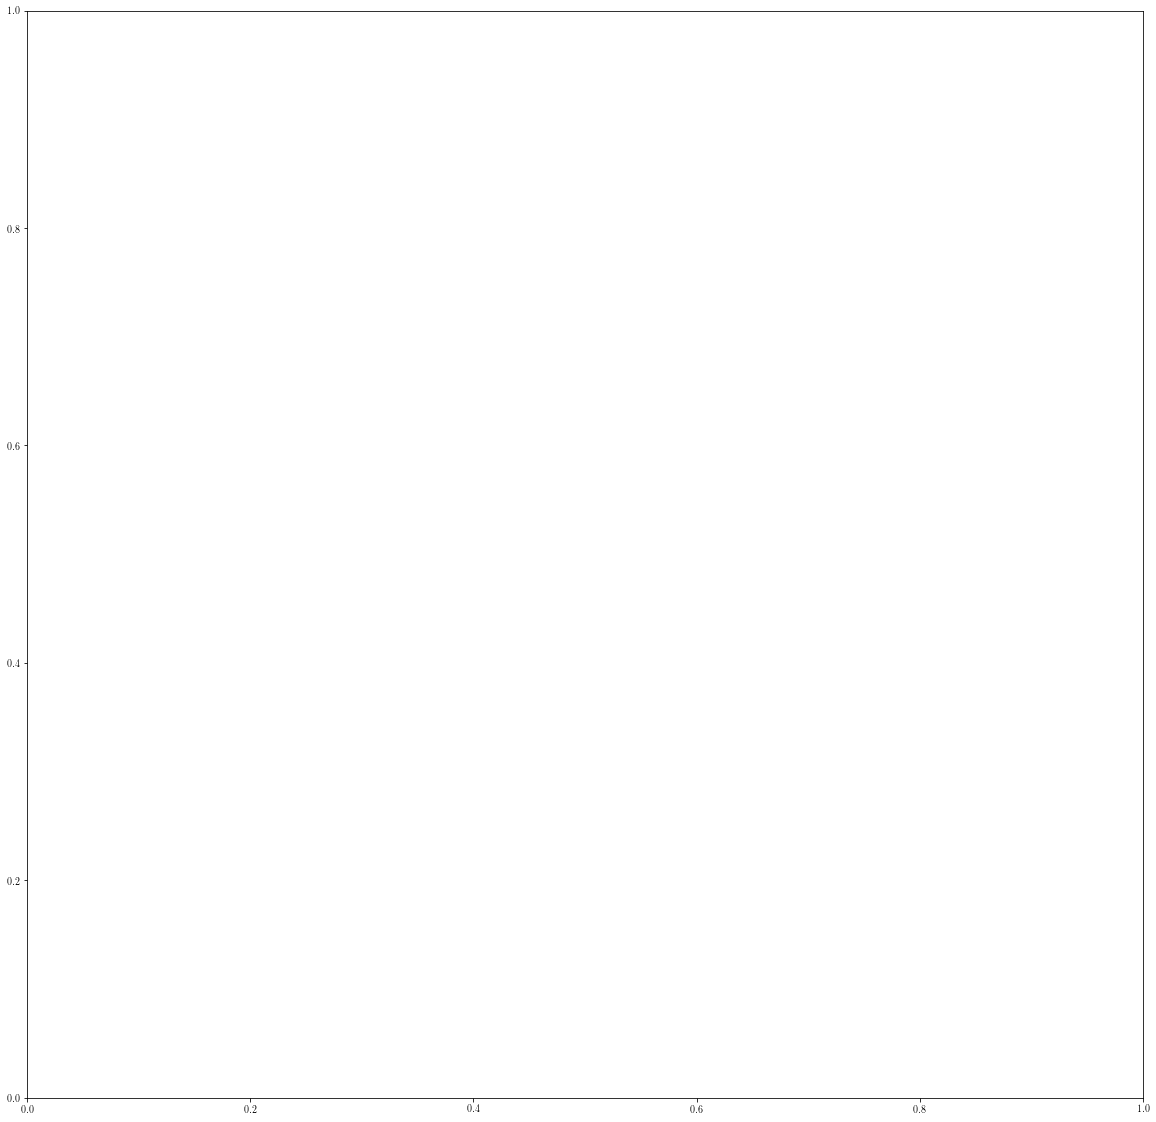

In [26]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))


labs = 40 #labelsize
digs = 35 #numbersize

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(a,1, figsize=(20,20), sharex=True)

mid_val = 0.0

#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS[a-1].set_xlabel("$k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$", size=25)
axS[a-1].xaxis.set_label_coords(0.5,-0.2)

for i in range(0,(a-1)):
    axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))
    #axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)

[axS[j].set_xscale('log') for j in range(0,a)]
[axS[j].set_yscale('log') for j in range(0,a)]
[axS[j].tick_params(axis='x', labelsize=30) for j in range(0,a)]
[axS[j].tick_params(axis='y', labelsize=30) for j in range(0,a)]
[axS[j].set_ylabel("$k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$", size=25) for j in range(0,a)]
#[axS[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
[axS[j].axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
[axS[j].axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]


cbar= shuttlingJ.colorbar(im, ax=axS.ravel().tolist(), shrink=0.95)
cbar.ax.tick_params(labelsize=30,length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current} \quad [Ms^{-1}]$", size=30, labelpad= 10)


#shuttlingJ.savefig('images/plots4Elisabeth/2_current.png', dpi=300)

plt.show()

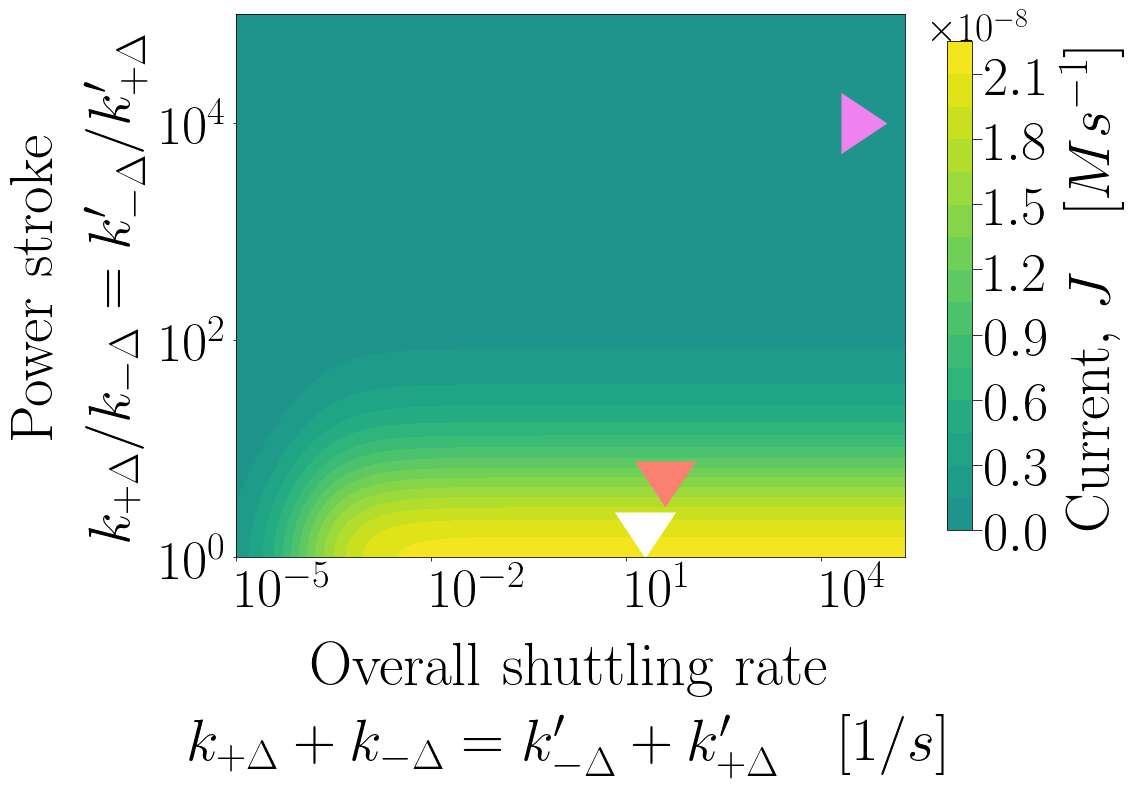

In [97]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))


labs = 60 #labelsize
digs = 55 #numbersize

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

mid_val = 0.0

#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$",linespacing=1.5 ,size=labs)
axS.xaxis.set_label_coords(0.5,-0.15)
axS.set_xticklabels(x, ha='left')



axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))
#axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=digs)
axS.tick_params(axis='y', labelsize=digs)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",linespacing=1.5 , size=labs)
#[axS[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS.axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
#[axS.axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

plt.plot(yc+gf,yc/gf, marker=7,markersize=labs,c='w')
plt.plot(1e4*gf,1e4, marker=5,markersize=labs,c='violet')
plt.plot(4*gf,3, marker=7,markersize=labs,c='salmon')


cbar= shuttlingJ.colorbar(im, ax=axS, shrink=0.9)
cbar.ax.tick_params(labelsize=digs,length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.ax.yaxis.get_offset_text().set_position((3.5,1))
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=labs, labelpad= 10)


shuttlingJ.savefig('images/plots4Elisabeth/station_affinity_J.png', dpi=300, bbox_inches='tight')
#shuttlingJ.savefig('Ben_ados/images/station_affinity_J.png', dpi=150)
#plt.tight_layout()


plt.show()

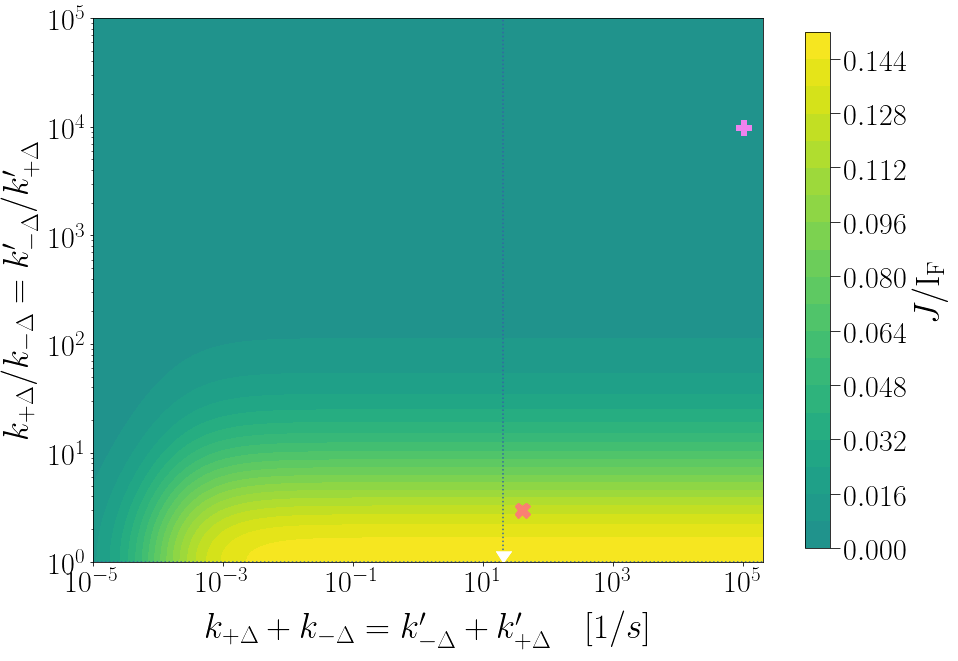

In [61]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

a = len(IFJRATIO)
shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

mid_val = 0.0

#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS.contourf(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS.set_xlabel("$k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$", size=35)
axS.xaxis.set_label_coords(0.5,-0.1)

axS.contourf(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$", size=35)
#[axS[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
axS.axhline(y=yc/gf, c='#3465A4', linestyle=':')
axS.axvline(x=yc+gf, c='#3465A4', linestyle=':') 

plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')
plt.plot(1e4*gf,1e4, marker='P',markersize=15,c='violet')
plt.plot(4*gf,3, marker='X',markersize=15,c='salmon')


cbar= shuttlingJ.colorbar(im, ax=axS, shrink=0.95)
cbar.ax.tick_params(labelsize=30,length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$J / \mathrm{I_F}$", size=35, labelpad= 10)

plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')
plt.plot(1e4*gf,1e4, marker='P',markersize=15,c='violet')
plt.plot(4*gf,3, marker='X',markersize=15,c='salmon')


#shuttlingJ.savefig('images/plots4Elisabeth/2_currentDRAFT.png', dpi=300)
shuttlingJ.savefig('Ben_ados/images/station_affinity_JoverIF.png', dpi=150)

plt.show()

### Effect on the efficiency

The yellow dotted line shows which value of r maximixes the efficiency given a certain yc.
The orange solid line shows which value of r maximizes $J_\mathrm{ss}$ (power) given a certain yc.
Ideally, one can use plots like these to find good trade-offs, where both the current and the efficiency are significantly high.

In [ ]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

shuttlingEff, axSE = plt.subplots(a,1, figsize=(20,20), sharex=True)

im = axSE[0].contourf(x,y,np.array(FUELINGEff[0]).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE[1].contourf(x,y,np.array(FUELINGEff[1]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[2].contourf(x,y,np.array(FUELINGEff[2]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[3].contourf(x,y,np.array(FUELINGEff[3]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[3].set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$", size=35)
axSE[3].xaxis.set_label_coords(0.5,-0.2)

[axSE[j].set_xscale('log') for j in range(0,a)]
[axSE[j].set_yscale('log') for j in range(0,a)]
[axSE[j].tick_params(axis='x', labelsize=30) for j in range(0,a)]
[axSE[j].tick_params(axis='y', labelsize=30) for j in range(0,a)]
[axSE[j].set_ylabel("$k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$", size=35) for j in range(0,a)]
[axSE[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axSE[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=15.0)  for j in range(0,a)]
[axSE[j].axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
[axSE[j].axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

cbar = shuttlingEff.colorbar(im, ax=axSE.ravel().tolist(), shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Efficiency}$", size=35, labelpad= 10)



#plt.axvline(x=6, c='#3465A4', linestyle=':')
#asS[2].set_xscale('log')

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
for i in range(0,a):
    FUNCTION = np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F')
    qfwfq = np.argmax(FUNCTION,axis=0)
    t_0 = []
    for j in range(0,len(qfwfq)):
        t_0.append(y[qfwfq[j]])
    axSE[i].plot(x,t_0,c='orange',linewidth='2')
####

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#for i in range(0,a):
#    FUNCTION = np.array(FUELINGEff[i]).reshape(len(y),len(x),order='F')
#    qfwfq = np.argmax(FUNCTION,axis=0)
#    t_0 = []
#    for j in range(0,len(qfwfq)):
#        t_0.append(y[qfwfq[j]])
#    axSE[i].plot(x,t_0,c='yellow',linewidth='2', linestyle=':')
####


shuttlingEff.savefig('images/plots4Elisabeth/2_efficiency.png', dpi=300)

plt.show()

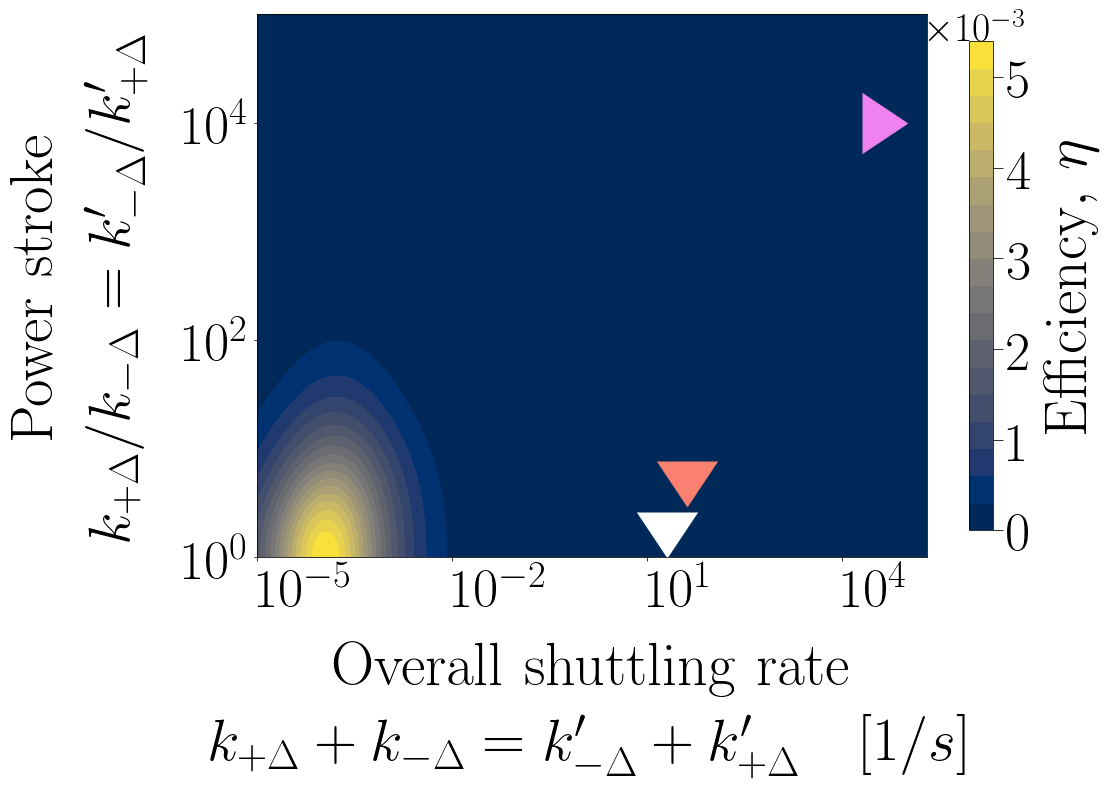

In [103]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))


labs = 60 #labelsize
digs = 55 #numbersize

shuttlingEff, axSE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axSE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$",linespacing=1.5 ,size=labs)
axSE.xaxis.set_label_coords(0.5,-0.15)
axSE.set_xticklabels(x, ha='left')

axSE.set_xscale('log')
axSE.set_yscale('log')
axSE.tick_params(axis='x', labelsize=digs)
axSE.tick_params(axis='y', labelsize=digs)
axSE.set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",linespacing=1.5 ,size=labs)
axSE.yaxis.set_label_coords(-0.15,0.5) 
#[axSE[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=15.0)  for j in range(0,a)]
#[axSE.axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
#[axSE.axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

cbar = shuttlingEff.colorbar(im, ax=axSE, shrink=0.9,ticks=[0, 1*1e-3,2*1e-3,3*1e-3,4*1e-3,5*1e-3])
cbar.ax.yaxis.get_offset_text().set_position((2.5,1))
cbar.ax.tick_params(labelsize=digs, length=10)
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.set_label("$\mathrm{Efficiency, \, \eta}$", size=labs, labelpad= 10)



#plt.axvline(x=6, c='#3465A4', linestyle=':')
#asS[2].set_xscale('log')

##### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#for i in range(0,a):
#    FUNCTION = np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F')
#    qfwfq = np.argmax(FUNCTION,axis=0)
#    t_0 = []
#    for j in range(0,len(qfwfq)):
#        t_0.append(y[qfwfq[j]])
#    axSE.plot(x,t_0,c='orange',linewidth='2')
#####

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#for i in range(0,a):
#    FUNCTION = np.array(FUELINGEff[i]).reshape(len(y),len(x),order='F')
#    qfwfq = np.argmax(FUNCTION,axis=0)
#    t_0 = []
#    for j in range(0,len(qfwfq)):
#        t_0.append(y[qfwfq[j]])
#    axSE[i].plot(x,t_0,c='yellow',linewidth='2', linestyle=':')
####
plt.plot(yc+gf,yc/gf, marker=7,markersize=labs,c='w')
plt.plot(1e4*gf,1e4, marker=5,markersize=labs,c='violet')
plt.plot(4*gf,3, marker=7,markersize=labs,c='salmon')

shuttlingEff.savefig('images/plots4Elisabeth/station_affinity_Eff.png', dpi=300, bbox_inches='tight')
#shuttlingEff.savefig('Ben_ados/images/station_affinity_Eff.png', dpi=150)
#plt.tight_layout()

plt.show()

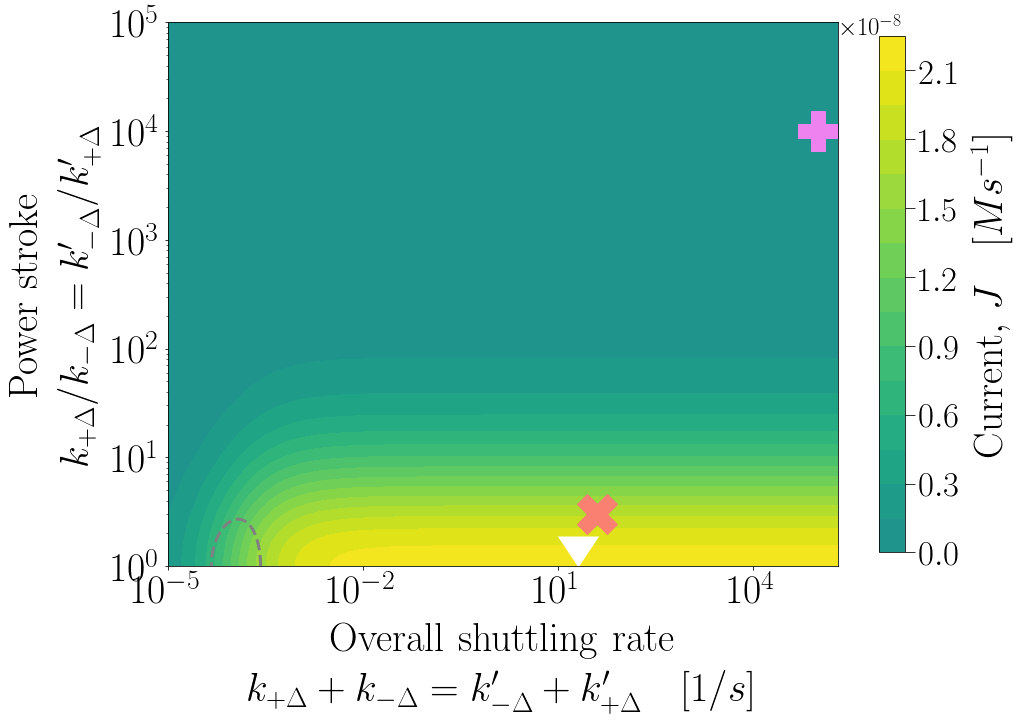

In [60]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

mid_val = 0.0

#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$",linespacing=1.5 ,size=40)
axS.xaxis.set_label_coords(0.5,-0.1)


axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))
#axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=40)
axS.tick_params(axis='y', labelsize=40)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",linespacing=1.5 , size=40)
#[axS[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS.axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
#[axS.axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

plt.plot(yc+gf,yc/gf, marker=7,markersize=40,c='w')
plt.plot(1e4*gf,1e4, marker='P',markersize=40,c='violet')
plt.plot(4*gf,3, marker='X',markersize=40,c='salmon')


cbar= shuttlingJ.colorbar(im, ax=axS, shrink=0.95)
cbar.ax.tick_params(labelsize=35,length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=40, labelpad= 10)



#test---
aaa = axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.0045],linewidths=3.0,linestyles='--' ,colors='gray')
#
#fmt = {}
#strs = ['$0.0004\%$', '$0.004\%$']
#for l, s in zip(aaa.levels, strs):
#    fmt[l] = s
##
### Label every other level using strings
#axF.clabel(aaa, aaa.levels, inline=True, fmt=fmt, fontsize=25)

shuttlingJ.savefig('images/plots4Elisabeth/station_affinity_ALL.png', dpi=300,bbox_inches='tight')

plt.show()

In [30]:
# Quick computations
F0= 0.03; W0 = 0.00001  ; LM = 0.01; ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]);
ss = fsolve(SS_solution,ssGuess,args=(yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM))
jss = yc*ss[2] - gf*ss[4]

#affinity/force
aff = R*T*log((fp*wlm)/(fm*wlp)) + R*T*(log(F0) - log(W0))

#currents
jss = yc*ss[2] - gf*ss[4]
ifuel = F0*(fp*ss[4] + fp*ss[5] + hp*ss[2] + hp*ss[3]) - (fm+hm)*(ss[1] + ss[0])

#work
wch = ifuel*aff

#info
imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))

#efficiency
ncd = R*T*imh/wch
print(jss)
print(ncd)

2.1670317925520655e-08
1.2533159279586223e-07


# SIMULATION 3A

Same as above. Concerning efficiency plots, in the following I avoid to use different colormaps on the same plots to distinguish the operating regimes. Instead, I added a dashed white line idicating where the information flow changes its sign.

In [104]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; IFJRATIO = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2; 
rt_min = 1e-2; rt_max = 1e2;
num = 100; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; JIF = [] ; FUEL.append(F0) #lists to renew each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num2):
            
            
            ylc = r*somma/(r+1)
            
            glc = ylc
            glf = ylc/r #sm defined accordingly o r and sp in the loop
            ylf = glf
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um #assuming also ts to benefit from the interaction: verify consist with chem pot 
            hlm = hm 
            hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
    
    IFJRATIO.append(np.array(JIF))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


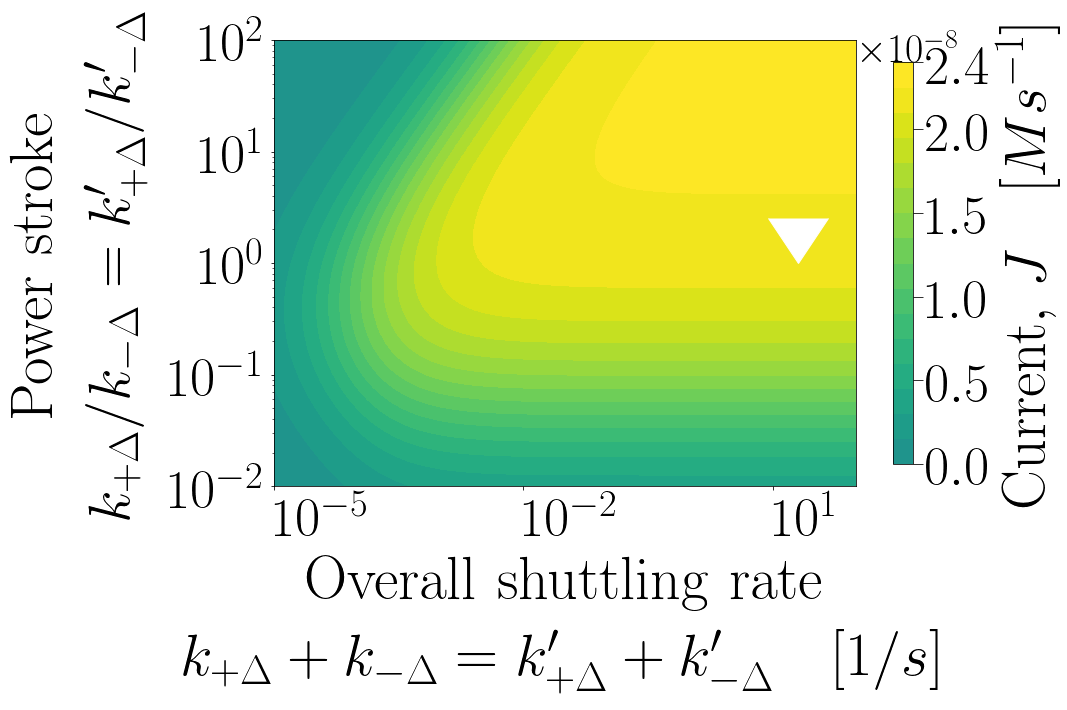

In [134]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))


labs = 60 #labelsize
digs = 55 #numbersize

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=labs)
axS.xaxis.set_label_coords(0.5,-0.15)
axS.set_xticklabels(x, ha='left')


axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=digs)
axS.tick_params(axis='y', labelsize=digs)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=labs)
axS.yaxis.set_label_coords(-0.2,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=labs,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.9,ticks=[0.0,0.5*1e-8,1.0*1e-8,1.5*1e-8,2.0*1e-8,2.4*1e-8])
cbar.ax.yaxis.get_offset_text().set_position((3.5,1))
cbar.ax.tick_params(labelsize=digs, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=labs, labelpad= 5)

plt.tight_layout()

shuttlingJ.savefig('images/plots4Elisabeth/3A_current.png', dpi=300, bbox_inches='tight')
#shuttlingJ.savefig('Ben_ados/images/CaseB_EnergyFlow.png', dpi=150)

plt.show()

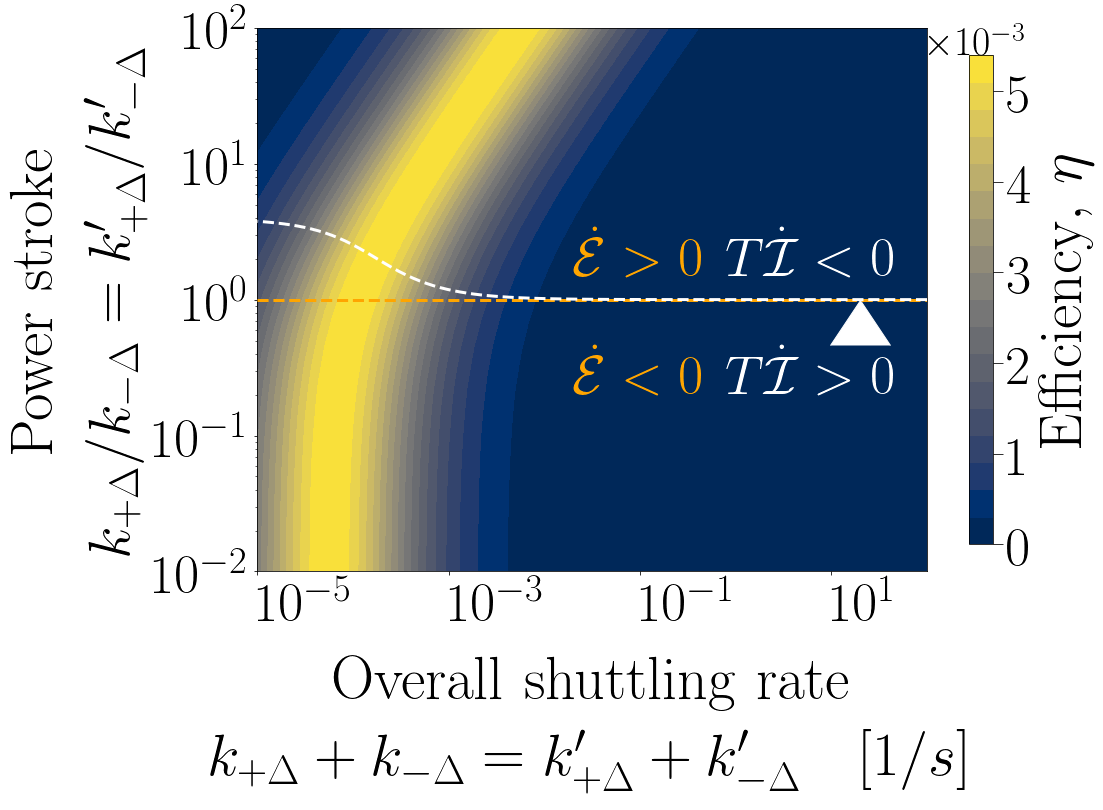

In [145]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

labs = 60 #labelsize
digs = 55 #numbersize

shuttlingEff3, axSE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axSE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
#axSE.set_xticklabels(axSE.get_xticks(), ha='left')
axSE.set_xticklabels(x, ha='left')
axSE.set_xscale('log')
axSE.set_yscale('log')
axSE.tick_params(axis='x', labelsize=digs)
axSE.tick_params(axis='y', labelsize=digs)
axSE.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=labs)
axSE.xaxis.set_label_coords(0.5,-0.15)
axSE.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=labs)
axSE.yaxis.set_label_coords(-0.15,0.5)
#axSE.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axSE.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axSE.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)



axSE.axhline(y=1, c='orange', linestyle='--',linewidth=3.0, zorder=5) 
axSE.contour(x,y,np.array(INFOFLOW).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w',zorder=10)

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#FUNCTION = np.array(FUELINGJ).reshape(len(y),len(x),order='F')
#qfwfq = np.argmax(FUNCTION,axis=0)
#t_0 = []
#for j in range(0,len(qfwfq)):
#    t_0.append(y[qfwfq[j]])
#axSE.plot(x,t_0,c='orange',linewidth='3')
####
plt.plot(yc+gf,yc/gf, marker=6,markersize=labs,c='w')

plt.text(0.8, 1.5, '$T\dot{\mathcal{I}}<0$',size=digs, color='w')
plt.text(0.8, 0.2, '$T\dot{\mathcal{I}}>0$',size=digs, color='w')
plt.text(0.02, 1.5, '$\dot{\mathcal{E}}>0$',size=digs, color='orange')
plt.text(0.02, 0.2, '$\dot{\mathcal{E}}<0$',size=digs, color='orange')


cbar = shuttlingEff3.colorbar(im, shrink=0.9,ticks=[0, 1*1e-3,2*1e-3,3*1e-3,4*1e-3,5*1e-3])
cbar.ax.tick_params(labelsize=digs, length=10)
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.ax.yaxis.get_offset_text().set_position((2.5,1))
cbar.set_label("$\mathrm{Efficiency}, \, \eta$", size=labs, labelpad= 5)


#plt.tight_layout()



shuttlingEff3.savefig('images/plots4Elisabeth/3A_efficiency.png', dpi=300, bbox_inches='tight')


plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


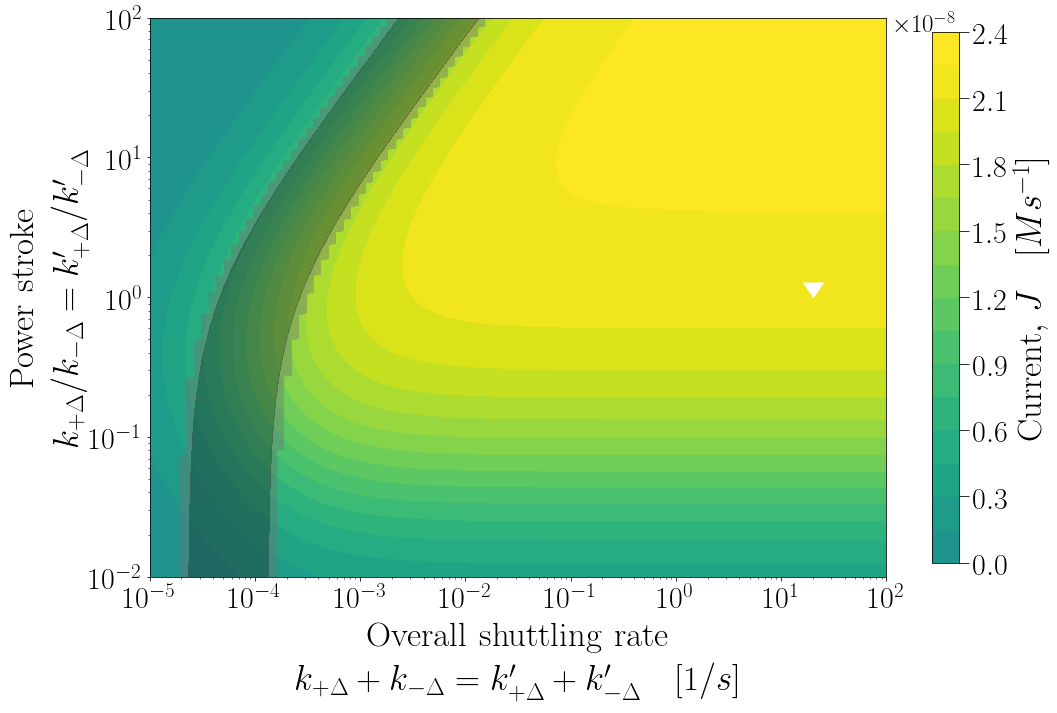

In [9]:
#tentativo di trasparenza
import scipy.ndimage

x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=20,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

plt.tight_layout()

#shuttlingJ.savefig('images/plots4Elisabeth/3A_current.png', dpi=300)
#shuttlingJ.savefig('Ben_ados/images/CaseB_EnergyFlow.png', dpi=150)


imh_mask = np.array(FUELINGEff).reshape(len(y),len(x), order='F')
eff_regime = np.array(FUELINGEff).reshape(len(y),len(x),order='F')
eff_regime = np.ma.array(eff_regime, mask=imh_mask < 0.004)
#smooth = scipy.ndimage.zoom(eff_regime, 3)
im = axS.contourf(x,y,eff_regime,0, vmin=0, cmap='Greys', alpha=0.4)

#shuttlingJ.savefig('images/plots4Elisabeth/test_efficiency_region.png', dpi=300, bbox_inches='tight')

plt.show()

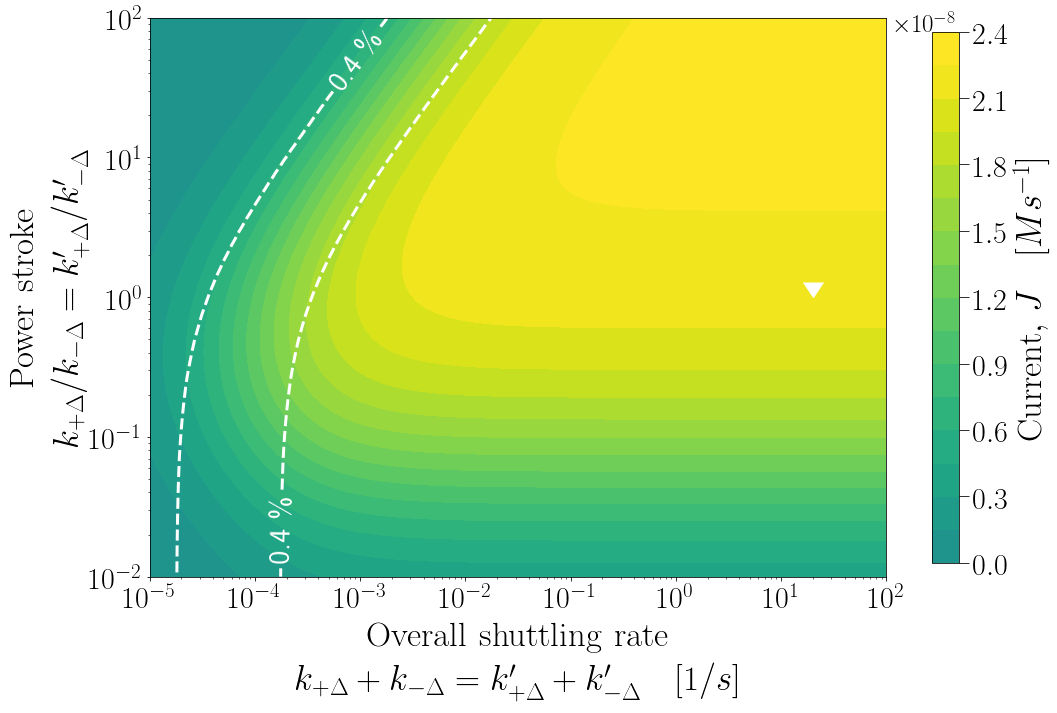

In [56]:
#tentativo di trasparenza
import scipy.ndimage

x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=20,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

plt.tight_layout()

#axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.004],linewidths=3.0,linestyles='--' ,colors='w')

#test---
aaa = axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.004],linewidths=3.0,linestyles='--' ,colors='w')
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Recast levels to new class
aaa.levels = [nf(val*100) for val in aaa.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(aaa, aaa.levels, inline=True, fmt=fmt, fontsize=30)

#per scriverci tipo eta=... : https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contour_label_demo.html


#-----
#smooth = scipy.ndimage.zoom(eff_regime, 3)
#aaa = axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.004],linewidths=3.0,linestyles='--' ,colors='w')



#shuttlingJ.savefig('images/plots4Elisabeth/test_efficiency_region.png', dpi=300, bbox_inches='tight')

plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


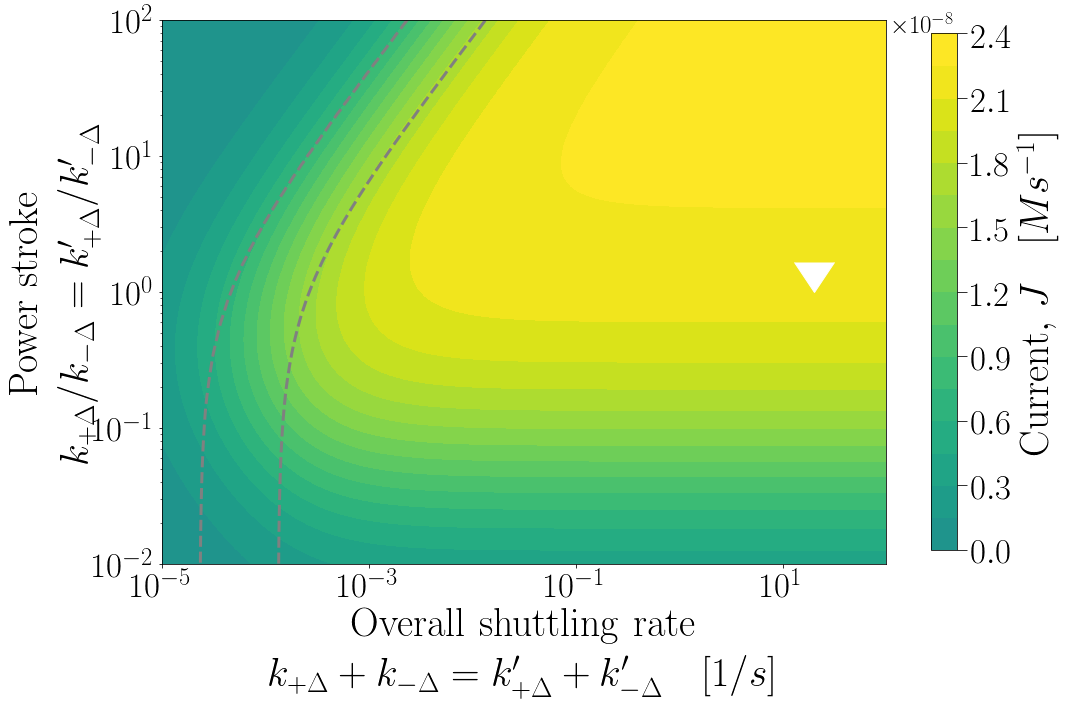

In [58]:
#tentativo di trasparenza
import scipy.ndimage

x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=40)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=35)
axS.tick_params(axis='y', labelsize=35)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=40)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=40,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=35, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=40, labelpad= 5)

plt.tight_layout()

#axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.004],linewidths=3.0,linestyles='--' ,colors='w')


#test---
aaa = axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.0045],linewidths=3.0,linestyles='--' ,colors='gray')
#
#fmt = {}
#strs = ['$0.0004\%$', '$0.004\%$']
#for l, s in zip(aaa.levels, strs):
#    fmt[l] = s
##
### Label every other level using strings
#axF.clabel(aaa, aaa.levels, inline=True, fmt=fmt, fontsize=25)

shuttlingJ.savefig('images/plots4Elisabeth/Eflow_ALL.png', dpi=300,bbox_inches='tight')

#-----
#smooth = scipy.ndimage.zoom(eff_regime, 3)
#aaa = axS.contour(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),[0.004],linewidths=3.0,linestyles='--' ,colors='w')


plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


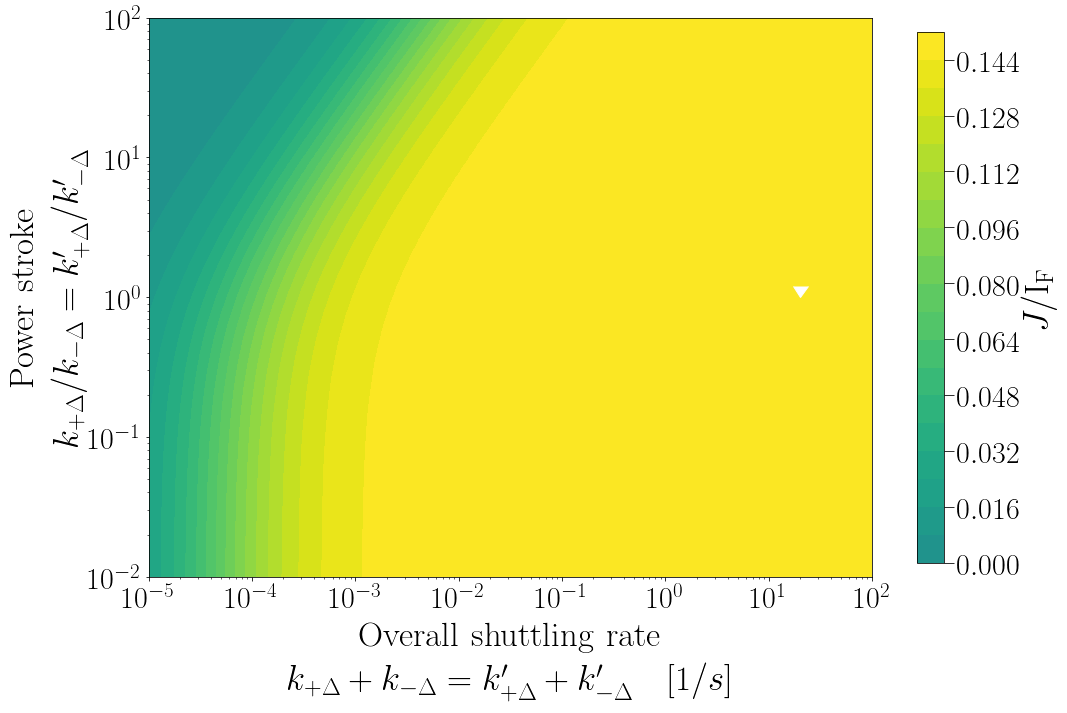

In [28]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(IFJRATIO[0])
elev_max=max(IFJRATIO[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$J/\mathrm{I_F}$", size=35, labelpad= 5)

plt.tight_layout()

#shuttlingJ.savefig('images/plots4Elisabeth/3A_current.png', dpi=300)
shuttlingJ.savefig('Ben_ados/images/CaseB(costantKr)_JoverIF.png', dpi=150)

plt.show()

# SIMULATION 3B

In [29]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = []; IFJRATIO = []; 
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-4; sp_max = 1e2; 
rt_min = 5e-4; rt_max = 5e2;
num = 100; num2= 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; JIF = []; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num2):
            
            ylc = r*somma/(r+1)
        
            glc = ylc
            glf = ylc/r #sm defined accordingly o r and sp in the loop
            ylf = glf
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um #assuming also ts to benefit from the interaction: verify consist with chem pot 
            hlp = hp 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
    
    IFJRATIO.append(np.array(JIF))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


### Effect on the current $J_\mathrm{ss}$

Note that below the horizontal black line negative values for the current are obtained.

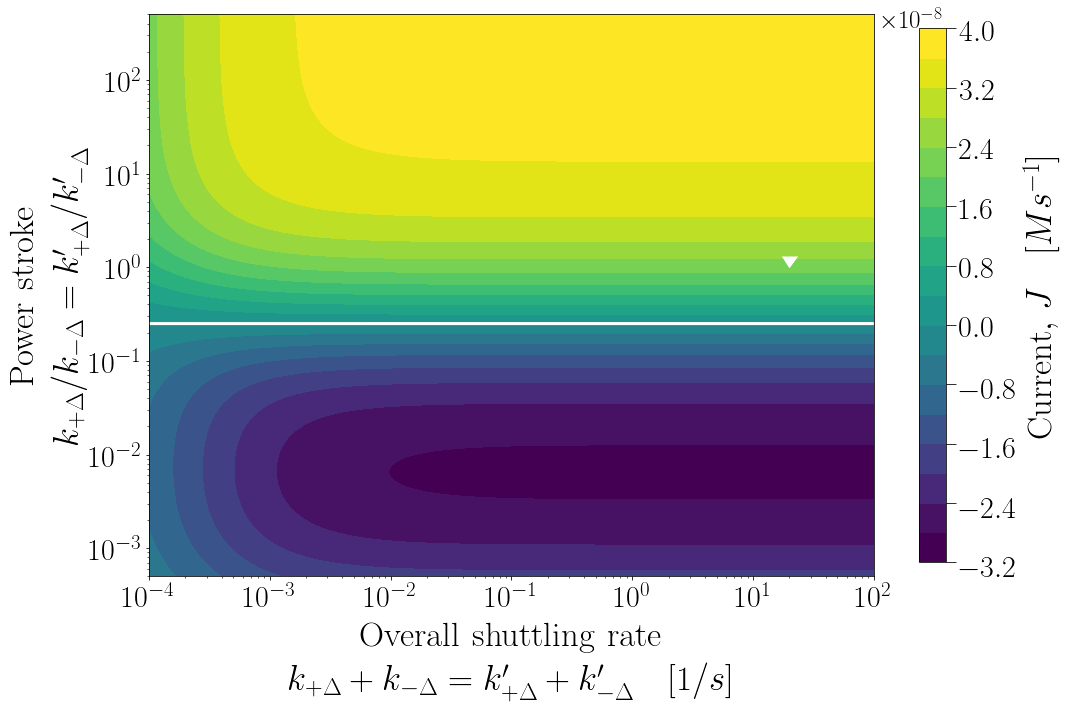

In [30]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ[0]).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')


axS.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=3.0)


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

plt.tight_layout()

shuttlingJ.savefig('images/plots4Elisabeth/3B_current.png', dpi=300)

plt.show()

### Effect on the efficiency

Note that the plots only show regions in which the motor is working in a chemical maxwell demon regime, so where the information ratchet contribution $\dot{I}$ is positive. In this region, the definition of efficiency changes depending on whether the motor is in a mixed (info- and energy-ratchet both positive) on in an energy transduction (negative energy ratchet) regime. The grey areas indicate that there the motor is only energy-driven (info-ratchet negative), with the current flowing conterclockwise in the bottom parts of the plots. (the ugly grainy effects in the plots are due to the small sampling of points I am using to keep the computation light, of course they will be improved if we decide to use them for the paper). The orange solid line shows where the information ratchet contribution is maximized for a given value of yc.



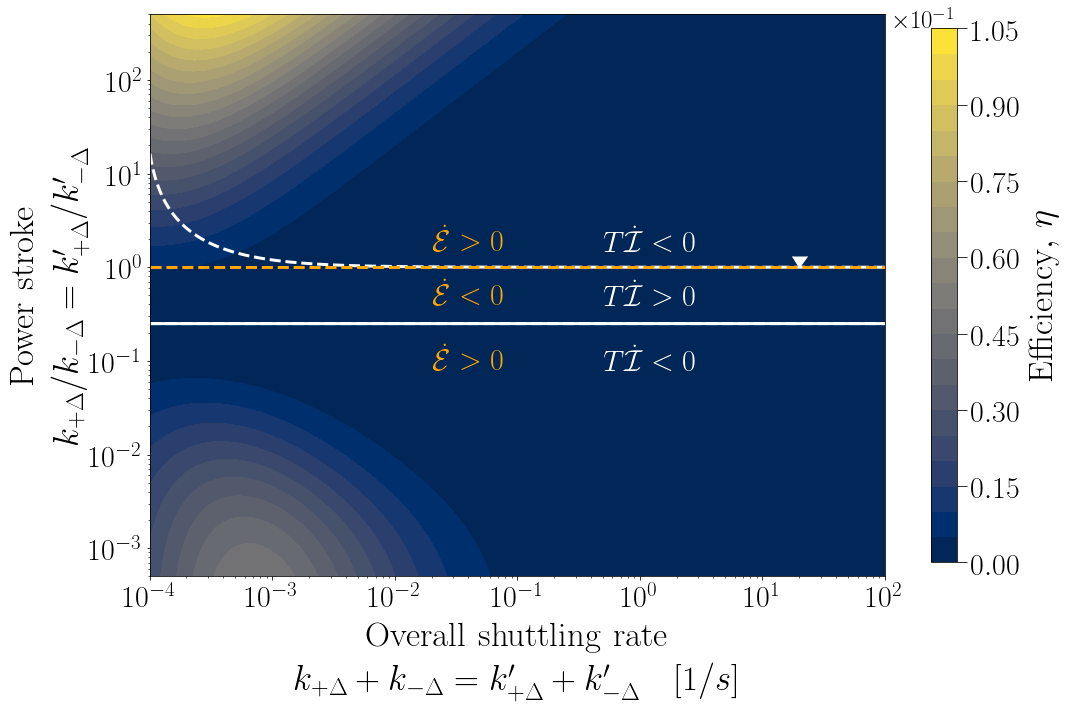

In [23]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingEff3, axSE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axSE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE.set_xscale('log')
axSE.set_yscale('log')
axSE.tick_params(axis='x', labelsize=30)
axSE.tick_params(axis='y', labelsize=30)
axSE.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axSE.xaxis.set_label_coords(0.5,-0.075)
axSE.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axSE.yaxis.set_label_coords(-0.075,0.5)
#axSE.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axSE.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axSE.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)


axSE.contour(x,y,np.array(INFOFLOW).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w')
axSE.contour(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=3.0)

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#FUNCTION = np.array(FUELINGJ).reshape(len(y),len(x),order='F')
#qfwfq = np.argmax(FUNCTION,axis=0)
#t_0 = []
#for j in range(0,len(qfwfq)):
#    t_0.append(y[qfwfq[j]])
#axSE.plot(x,t_0,c='orange',linewidth='2')
####
axSE.axhline(y=1, c='orange', linestyle='--',linewidth=3.0) 
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')

plt.text(0.5, 1.5, '$T\dot{\mathcal{I}}<0$',size=30, color='w')
plt.text(0.5, 0.4, '$T\dot{\mathcal{I}}>0$',size=30, color='w')
plt.text(0.5, 0.08, '$T\dot{\mathcal{I}}<0$',size=30, color='w')
plt.text(0.02, 1.5, '$\dot{\mathcal{E}}>0$',size=30, color='orange')
plt.text(0.02, 0.4, '$\dot{\mathcal{E}}<0$',size=30, color='orange')
plt.text(0.02, 0.08,'$\dot{\mathcal{E}}>0$',size=30, color='orange')


cbar = shuttlingEff3.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Efficiency}, \, \eta$", size=35, labelpad= 5)

plt.tight_layout()



shuttlingEff3.savefig('images/plots4Elisabeth/3B_efficiency.png', dpi=300)


plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


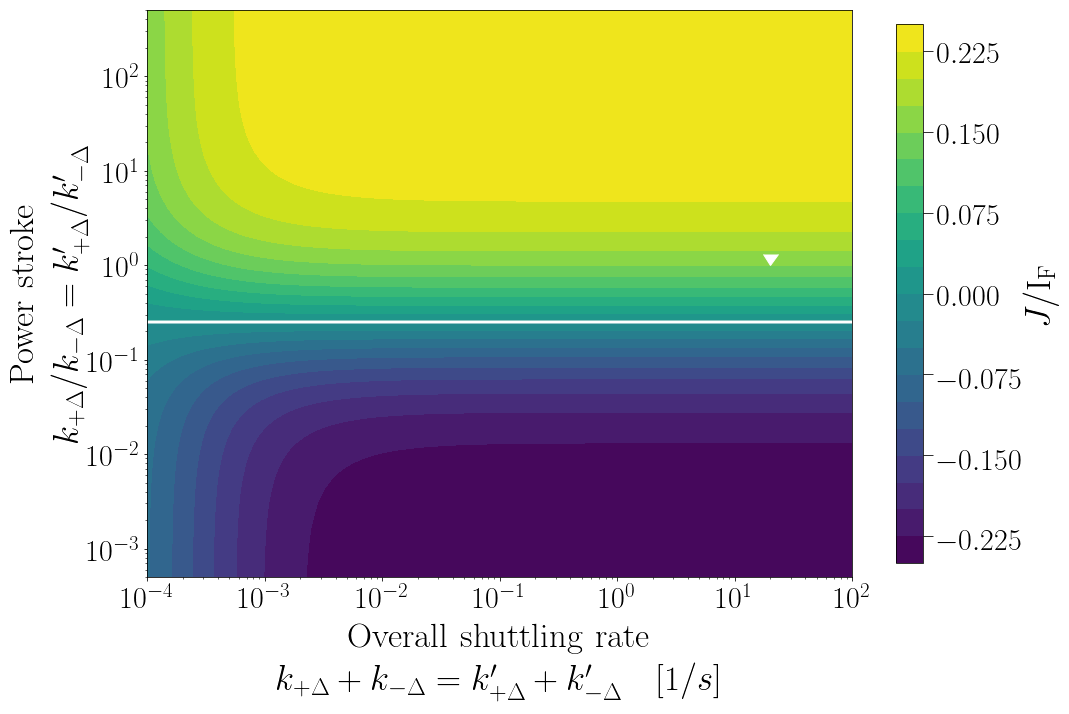

In [32]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(IFJRATIO[0])
elev_max=max(IFJRATIO[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(IFJRATIO[0]).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')


axS.contour(x,y,np.array(IFJRATIO).reshape(len(y),len(x),order='F'),[0.0], colors='w', linestyles='-',linewidths=3.0)


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$J/\mathrm{I_F}$", size=35, labelpad= 5)

plt.tight_layout()

shuttlingJ.savefig('Ben_ados/images/CaseC(varyingKr)_JoverIF.png', dpi=150)


plt.show()

# ALTERNATIVE PLOTS: SYMMETRIC/ANTISYMMETRIC PARTS

# SIMULATION 2: Station affinity

Since in the "old" plots we were always arbitrary picking the clockwise shuttling constant as variable in the x-axis, we had a bias in the plots' symmetry also here. 

We could solve the issue in the same way (plotting the sum $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta}$), but since we are modyfing states' stability here, there's a more meaningful way from theoretical point of view: plotting against the square root of the product ($\sqrt{k_{+\Delta}k_{-\Delta}}$).

I try to explain why this makes a lot of sense in the following.

Consider a simple thermal reaction from a state called "+" with energy/standard chemical potential $E_+$ to a state called "-":
<div>
<img src="images/simple_barrier.png" width="300"/>
</div>




In the framework of transition state theory, the Arrhenius/Eyring rates take the form:
- $k_{+\Delta} = A e^{-\beta \Delta E^\ddagger_+} = A e^{-\beta ( E^\ddagger - E_+)}$
- $k_{-\Delta} = A e^{-\beta \Delta E^\ddagger_-} = A e^{-\beta (E^\ddagger - E_-)}$

where $A$ is the Arrhenius factor and $\beta = 1/RT$. Now, consider the following algebraic manipulations:

- $k_{+\Delta} = 
k_{+\Delta} \cdot e^{-\frac{\beta}{2} (E_- - E_-)} = 
A e^{-\beta (E^\ddagger - \frac{E_+ + E_-}{2})} e^{-\beta \frac{(E_- - E_+)}{2}}$
- $k_{-\Delta} = 
k_{-\Delta} \cdot e^{-\frac{\beta}{2} (E_+ - E_+)} = 
A e^{-\beta (E^\ddagger - \frac{E_+ + E_-}{2})} e^{-\beta \frac{(E_+ - E_-)}{2}}$

The above equations show that rate constants are determined by a "symmetric/kinetic part" ($A e^{-\beta (E^\ddagger - \frac{E_+ + E_-}{2})} = \sqrt{k_{+\Delta}k_{-\Delta}}$) equal for both the forward and the backward process, and an "asymmetric/thermodynamic part" ($e^{-\beta \frac{(E_+ - E_-)}{2}} = \sqrt{\frac{k_{+\Delta}}{k_{-\Delta}}}$) only due to the difference in state's stability.

As a consequence, a very nice way to plot our results when acting on states's stabilities is to choose the "thermodynamic part" as y-axis and the "kinetic part" as x, as done in the following. This separation of the rates into a thermodynamic part (related to dissipation) and a kinetic part (related to a quantity called "frenesy") is very common in the physics literature and thus adds an element to the Rosetta's Stone story!

If you think that using square roots may confuse the reader, we can drop them since they are not fundamental for what we want to communicate. However I think it would be easy to justify the choice by adding something like the folowing equation in the SI:

$k_{+\Delta} = \sqrt{k_{+\Delta}k_{-\Delta}} \cdot \sqrt{\frac{k_{+\Delta}}{k_{-\Delta}}} \,, \quad 
k_{-\Delta} = \sqrt{k_{+\Delta}k_{-\Delta}} \cdot \left(\sqrt{\frac{k_{+\Delta}}{k_{-\Delta}}}\right)^{-1}$

where the first factor in both the equalities is only determined by relative barrier's heights (differences $E^\ddagger - E_+$ and $E^\ddagger - E_-$), while the second is only determined by relative states' stability (difference $E_+ - E_-$).


In [16]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2; 
rt_min = 1e-1; rt_max = 1e1;
num = 300;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.003, 0.03, 0.3, 3]:
    Eff = []; Jt = []; Imh = []; FUEL.append(F0) #lits to renew on each cycles and collection of fuel values
    for symm in np.geomspace(sp_min,sp_max,num):
        for asymm in np.geomspace(rt_min,rt_max,num):
            
            #check for Ben
            ylc = symm*asymm
            
            ylf = ylc
            glf = ylc/asymm**2 #sm defined accordingly o r and sp in the loop
            glc = glf
            wlm = wm 
            ulm = um 
            flm = fm 
            flp = fp 
            hlp = hp 
            wlp = wp
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #efficiency
            ncd = R*T*imh/wch
            Eff.append(ncd)
            
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))


/home/emanuele/venv_research/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


### Effect on the current $J_\mathrm{ss}$

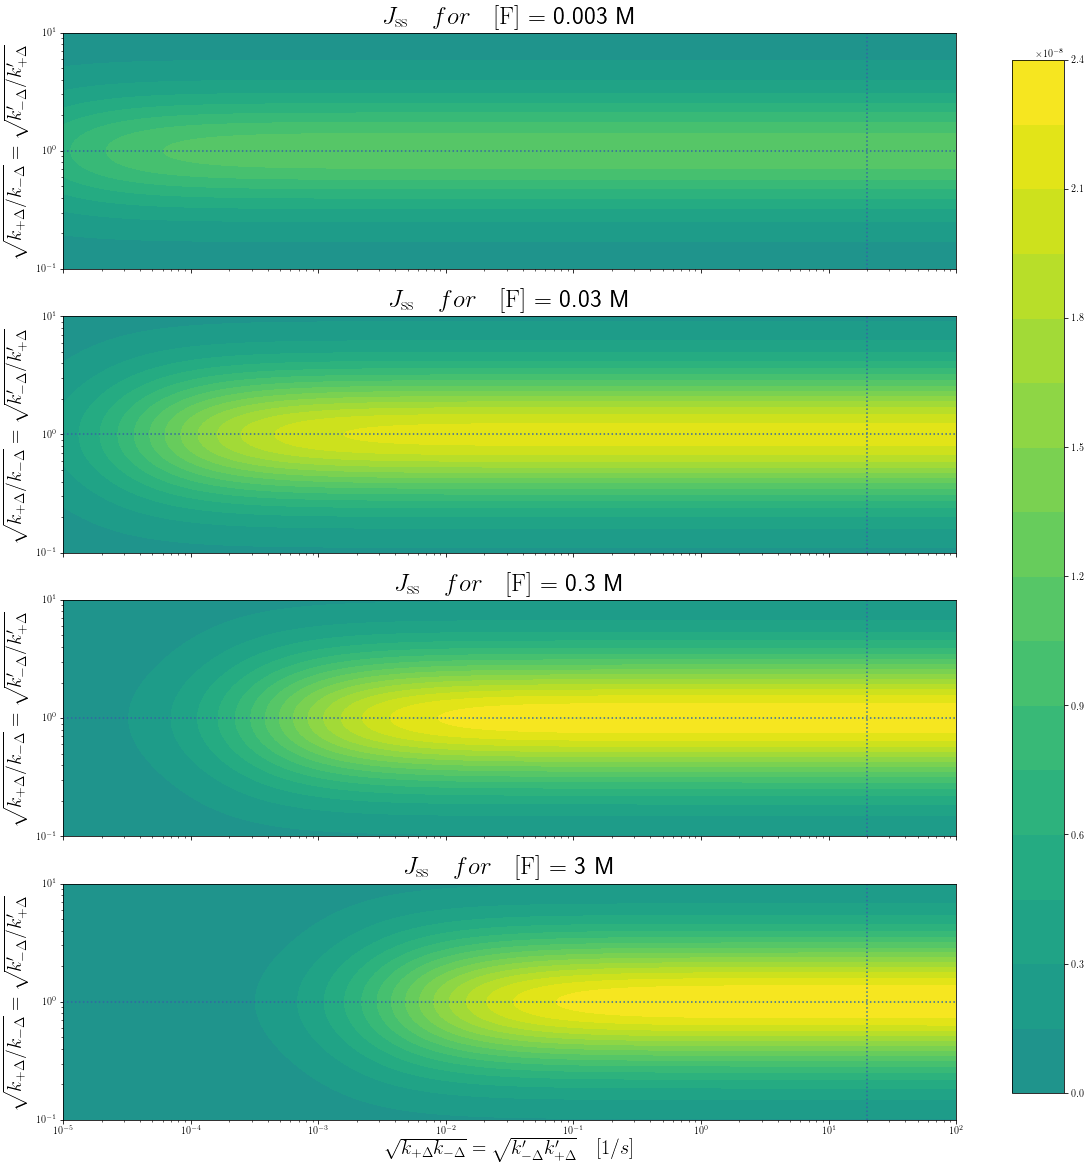

In [17]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(a,1, figsize=(20,20), sharex=True)



#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS[a-1].set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{-\Delta}k'_{+\Delta}} \quad [1/s]$", size=20)
for i in range(0,(a-1)):
    axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))
    #axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)

[axS[j].set_xscale('log') for j in range(0,a)]
[axS[j].set_yscale('log') for j in range(0,a)]
[axS[j].set_ylabel("$\sqrt{k_{+\Delta}/k_{-\Delta}} = \sqrt{k'_{-\Delta}/k'_{+\Delta}}$", size=20) for j in range(0,a)]
[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25)  for j in range(0,a)]
[axS[j].axhline(y=1, c='#3465A4', linestyle=':') for j in range(0,a)]
[axS[j].axvline(x=20, c='#3465A4', linestyle=':') for j in range(0,a)]


shuttlingJ.colorbar(im, ax=axS.ravel().tolist(), shrink=0.95)

#shuttlingJ.savefig('images/presentation/BEN_3A', dpi=300)

plt.show()

### Effect on the efficiency

The yellow dotted line shows which value of r maximixes the efficiency given a certain yc.
The orange solid line shows which value of r maximizes $J_\mathrm{ss}$ (power) given a certain yc.
Ideally, one can use plots like these to find good trade-offs, where both the current and the efficiency are significantly high.

In [18]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

shuttlingEff, axSE = plt.subplots(a,1, figsize=(20,20), sharex=True)

im = axSE[0].contourf(x,y,np.array(FUELINGEff[0]).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE[1].contourf(x,y,np.array(FUELINGEff[1]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[2].contourf(x,y,np.array(FUELINGEff[2]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[3].contourf(x,y,np.array(FUELINGEff[3]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[3].set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{-\Delta}k'_{+\Delta}} \quad [1/s]$", size=20)

[axSE[j].set_xscale('log') for j in range(0,a)]
[axSE[j].set_yscale('log') for j in range(0,a)]
[axSE[j].set_ylabel("$\sqrt{k_{+\Delta}/k_{-\Delta}} = \sqrt{k'_{-\Delta}/k'_{+\Delta}}$", size=20) for j in range(0,a)]
[axSE[j].set_title('$\eta_\mathrm{cd} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=20)  for j in range(0,a)]
[axSE[j].axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
[axSE[j].axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

shuttlingEff.colorbar(im, ax=axSE.ravel().tolist(), shrink=0.95)

#plt.axvline(x=6, c='#3465A4', linestyle=':')
#asS[2].set_xscale('log')

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
for i in range(0,a):
    FUNCTION = np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F')
    qfwfq = np.argmax(FUNCTION,axis=0)
    t_0 = []
    for j in range(0,len(qfwfq)):
        t_0.append(y[qfwfq[j]])
    axSE[i].plot(x,t_0,c='orange',linewidth='2')
####

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#for i in range(0,a):
#    FUNCTION = np.array(FUELINGEff[i]).reshape(len(y),len(x),order='F')
#    qfwfq = np.argmax(FUNCTION,axis=0)
#    t_0 = []
#    for j in range(0,len(qfwfq)):
#        t_0.append(y[qfwfq[j]])
#    axSE[i].plot(x,t_0,c='yellow',linewidth='2', linestyle=':')
####


#shuttlingEff.savefig('images/presentation/BEN/BEN_3B', dpi=300)

plt.show()

# SIMULATION 3A

Same as above. Concerning efficiency plots, in the following I avoid to use different colormaps on the same plots to distinguish the operating regimes. Instead, I added a dashed white line idicating where the information flow changes its sign.

In [49]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-6; sp_max = 1e2; 
rt_min = 1e-1; rt_max = 1e1;
num = 200; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for symm in np.geomspace(sp_min,sp_max,num):
        for asymm in np.geomspace(rt_min,rt_max,num2):
            
            ylc= symm*asymm
            glc = ylc
          #  glf = ylc/asymm**2 #sm defined accordingly o r and sp in the loop
            glf = symm/asymm
            ylf = glf
            
          #  glf = symm/asymm
          #  ylf = glf
          #  ylc = symm*asymm #sm defined accordingly o r and sp in the loop
          #  glc = ylc
            
            
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um #assuming also ts to benefit from the interaction: verify consist with chem pot 
            hlm = hm 
            hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
            
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


In [50]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{+\Delta}k'_{-\Delta}} \quad [1/s]$", size=20)

axS.set_xscale('log')
axS.set_yscale('log')
axS.set_ylabel("$\sqrt{{k_{+\Delta}}/{k_{-\Delta}}} = \sqrt{{k'_{+\Delta}}/{k'_{-\Delta}}}$", size=20)
axS.set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s'%FUEL, size=20)
axS.axhline(y=1, c='#3465A4', linestyle=':') 
#axS.axvline(x=10, c='#3465A4', linestyle=':')


shuttlingJ.colorbar(im, shrink=0.95)

#shuttlingJ.savefig('images/presentation/BEN_4A', dpi=300)

plt.show()

In [217]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingEff3, axSE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axSE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE.set_xscale('log')
axSE.set_yscale('log')
axSE.set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{+\Delta}k'_{-\Delta}} \quad [1/s]$", size=20)
axSE.set_ylabel("$\sqrt{{k_{+\Delta}}/{k_{-\Delta}}} = \sqrt{{k'_{+\Delta}}/{k'_{-\Delta}}}$", size=20)
axSE.set_title('$\eta \quad for \quad [\mathrm{F}] =$ %s'%FUEL, size=20)
axSE.axhline(y=1, c='#3465A4', linestyle=':') 
#axSE.axvline(x=10, c='#3465A4', linestyle=':')


axSE.contour(x,y,np.array(INFOFLOW).reshape(len(y),len(x),order='F'),[0.0],linewidths=2.0,linestyles='--' ,colors='w')

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
FUNCTION = np.array(FUELINGJ).reshape(len(y),len(x),order='F')
qfwfq = np.argmax(FUNCTION,axis=0)
t_0 = []
for j in range(0,len(qfwfq)):
    t_0.append(y[qfwfq[j]])
axSE.plot(x,t_0,c='orange',linewidth='2')
####

shuttlingEff3.colorbar(im, shrink=0.95)


#shuttlingEff3.savefig('images/presentation/BEN_4B', dpi=300)


plt.show()

# SIMULATION 3B

In [22]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-4; sp_max = 1e2; 
rt_min = 5e-2; rt_max = 5e1;
num = 300;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.003, 0.03, 0.3, 3]:
    Eff = []; Jt = []; Imh = []; ER = []; FUEL.append(F0) #lits to renew each cycles and collection of fuel values
    for symm in np.geomspace(sp_min,sp_max,num):
        for asymm in np.geomspace(rt_min,rt_max,num):
            
            ylc = symm*asymm
        
            glc = ylc
            glf = ylc/asymm**2 #sm defined accordingly o r and sp in the loop
            ylf = glf
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp
            ulm = um #assuming also ts to benefit from the interaction: verify consist with chem pot 
            hlp = hp 
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
            
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


### Effect on the current $J_\mathrm{ss}$

Note that below the horizontal black line negative values for the current are obtained.

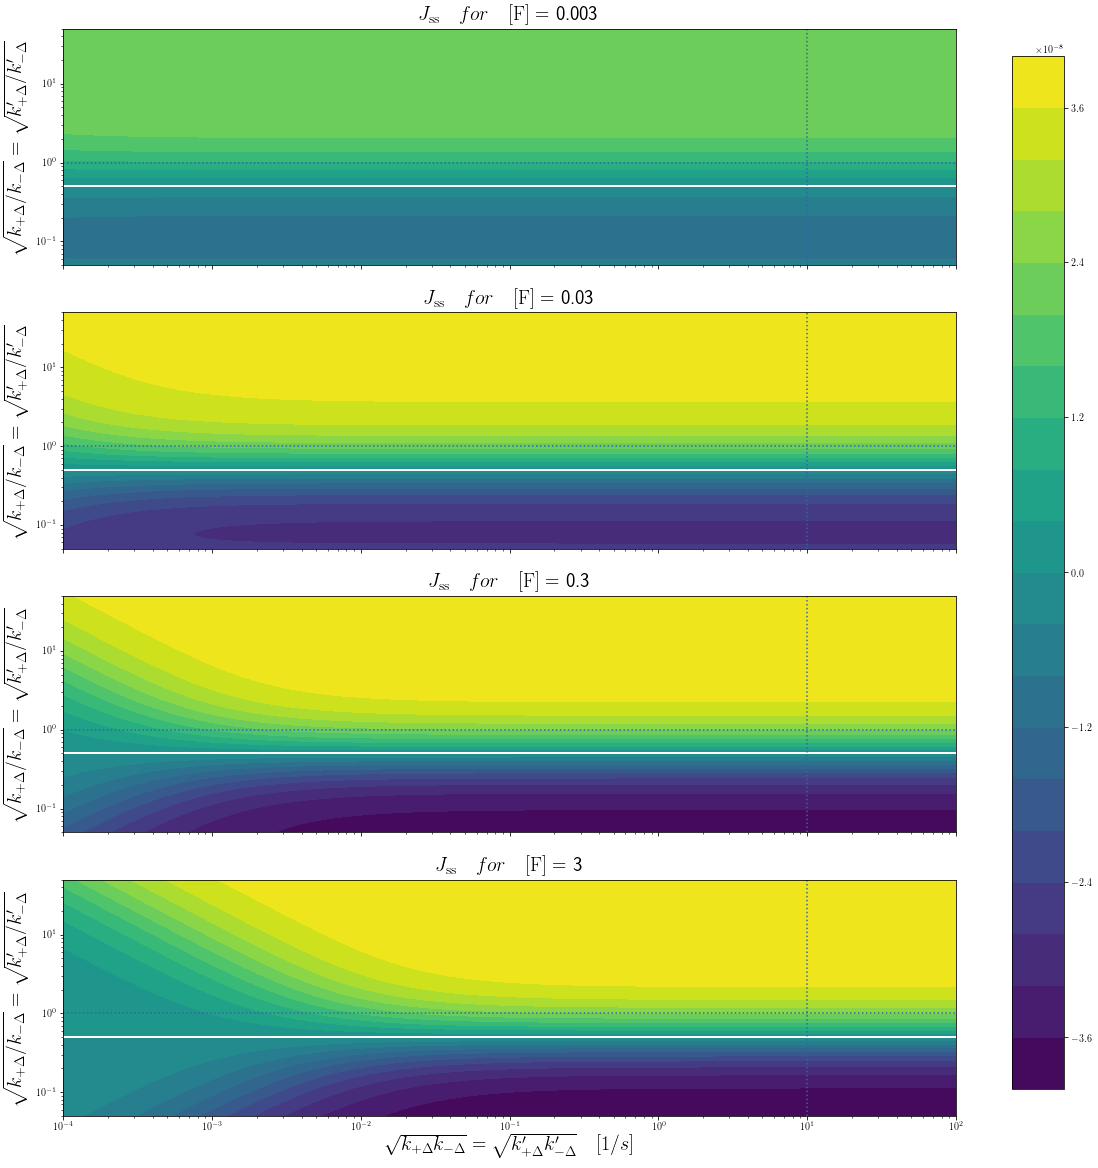

In [23]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(a,1, figsize=(20,20), sharex=True)

im = axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),20)
axS[a-1].set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{+\Delta}k'_{-\Delta}} \quad [1/s]$", size=20)
for i in range(0,(a-1)):
    axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),im.levels)

[axS[j].contour(x,y,np.array(FUELINGJ[j]).reshape(len(y),len(x),order='F'),[0.0],colors='white',linestyles='-',linewidths=2.0) for j in range(0,a)]
[axS[j].set_xscale('log') for j in range(0,a)]
[axS[j].set_yscale('log') for j in range(0,a)]
[axS[j].set_ylabel("$\sqrt{{k_{+\Delta}}/{k_{-\Delta}}} = \sqrt{{k'_{+\Delta}}/{k'_{-\Delta}}}$", size=20) for j in range(0,a)]
[axS[j].set_title('$J_\mathrm{ss} \quad for \quad[\mathrm{F}] = $ %s'%FUEL[j], size=20)  for j in range(0,a)]
[axS[j].axhline(y=1, c='#3465A4', linestyle=':') for j in range(0,a)]
[axS[j].axvline(x=10, c='#3465A4', linestyle=':') for j in range(0,a)]


shuttlingJ.colorbar(im, ax=axS.ravel().tolist(), shrink=0.95)

#shuttlingJ.savefig('images/presentation/BEN_simulation3B', dpi=300)

plt.show()

### Effect on the efficiency

Note that the plots only show regions in which the motor is working in a chemical maxwell demon regime, so where the information ratchet contribution $\dot{I}$ is positive. In this region, the definition of efficiency changes depending on whether the motor is in a mixed (info- and energy-ratchet both positive) on in an energy transduction (negative energy ratchet) regime. The grey areas indicate that there the motor is only energy-driven (info-ratchet negative), with the current flowing conterclockwise in the bottom parts of the plots. (the ugly grainy effects in the plots are due to the small sampling of points I am using to keep the computation light, of course they will be improved if we decide to use them for the paper). The orange solid line shows where the information ratchet contribution is maximized for a given value of yc.



In [24]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))

shuttlingEff, axSE = plt.subplots(a,1, figsize=(20,20), sharex=True)


im = axSE[2].contourf(x,y,np.array(FUELINGEff[2]).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE[1].contourf(x,y,np.array(FUELINGEff[1]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[0].contourf(x,y,np.array(FUELINGEff[0]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')
axSE[3].contourf(x,y,np.array(FUELINGEff[3]).reshape(len(y),len(x),order='F'),im.levels, cmap='cividis')

[axSE[j].set_xscale('log') for j in range(0,a)]
[axSE[j].set_yscale('log') for j in range(0,a)]
[axSE[j].set_ylabel("$\sqrt{k_{+\Delta}/k_{-\Delta}} = \sqrt{k'_{+\Delta}/k'_{-\Delta}}$", size=20) for j in range(0,a)]
[axSE[j].set_title('$\eta \quad for \quad[\mathrm{F}] = $ %s M'%FUEL[j], size=20)  for j in range(0,a)]
[axSE[j].axhline(y=1, c='#3465A4', linestyle=':') for j in range(0,a)]
[axSE[j].axvline(x=10, c='#3465A4', linestyle=':') for j in range(0,a)]

axSE[a-1].set_xlabel("$\sqrt{k_{+\Delta}k_{-\Delta}} = \sqrt{k'_{+\Delta}k'_{-\Delta}} \quad [1/s]$", size=20)

shuttlingEff.colorbar(im, ax=axSE.ravel().tolist(), shrink=0.95)


[axSE[j].contour(x,y,np.array(INFOFLOW[j]).reshape(len(y),len(x),order='F'),[0.0],
                linewidths=2.0,linestyles='--' ,colors='w') for j in range(0,a)]

[axSE[j].contour(x,y,np.array(FUELINGJ[j]).reshape(len(y),len(x),order='F'),[0.0],
                linewidths=2.0,linestyles='-' ,colors='w') for j in range(0,a)]



plt.show()

## Additional simulation (Ben dic 2020)

### Here I play with variation of standard fuel-to-waste chem pot differense and nonstandard (concentrations)

In [70]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = []; FET = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2; 
rt_min = 1e-2; rt_max = 1e2;
num = 100; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
Eff = []; Jt = []; Imh = []; ER = [];
for F0 in np.geomspace(0.003,3000,100):
    somma=20
    r= 10
            
            
    ylc = r*somma/(r+1)
    
    glc = ylc
    glf = ylc/r #sm defined accordingly o r and sp in the loop
    ylf = glf
    flp = fp 
    flm = fm 
    wlm = wm 
    wlp = wp
    ulm = um #assuming also ts to benefit from the interaction: verify consist with chem pot 
    hlm = hm 
    hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
    ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

    
    #call of the routines to solve rate equations
    ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
    ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#    eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#    eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
    
    #affinity/force
    aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
    AFF.append(aff)
    
    #currents
    jss = ylc*ss[2] - glf*ss[4]
    Jt.append(jss)
    ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
    
    #work
    wch = ifuel*aff
    
    #info
    imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
    Imh.append(imh)
    
    #energy ratchet
    er = jss*log((ylc*glc)/(glf*ylf))
    ER.append(er)
    
    #efficiency
    ncd = R*T*(imh+er)/wch 
    #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
    #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
    Eff.append(ncd)
    FET.append(R*T*(imh+er))

muFmuW = R*T*log((flp*wlm)/(flm*wlp)) #Std chemical potential gradient F-W
print(muFmuW)

32569.25645307593


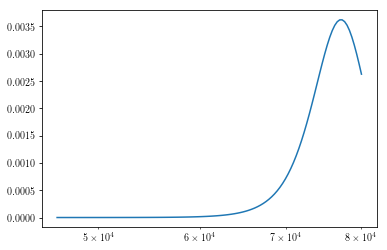

In [71]:
plt.plot(AFF,Eff)
plt.xscale('log')

In [ ]:
# Veryfy relation between increasing of parasite currents and decreasing of efficiency

In [42]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = []; FET = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2; 
rt_min = 1e-2; rt_max = 1e2;
num = 100; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
Eff = []; Jt = []; Imh = []; ER = []; JDIST = []; JPROX = []; JPARA = []; IF = []

F0 =0.03
r = 1
Eff = []; Jt = []; Imh = []; FUEL.append(F0) #lits to renew on each cycles and collection of fuel values
for somma in np.geomspace(sp_min,sp_max,num):
        #check for Ben
        ylc = r*somma/(r+1)
        
        ylf = ylc
        glf = ylc/r #sm defined accordingly o r and sp in the loop
        glc = glf
        wlm = wm 
        ulm = um 
        flm = fm 
        flp = fp 
        hlp = hp 
        wlp = wp
        hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
        ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

        #call of the routines to solve rate equations
        ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
        ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
       # eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
        #eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
        
        #affinity/force
        aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
        
        #currents
        jss = ylc*ss[2] - glf*ss[4]
        Jt.append(jss)
        ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
        IF.append(ifuel)
        jdist = (F0*flp*ss[4] - flm*ss[1]) - jss
        JDIST.append(jdist)
        jprox = (ulm*ss[0] - W0*ulp*ss[2]) - jss
        JPROX.append(jprox)
        JPARA.append(jprox+jdist)
        
        #work
        wch = ifuel*aff
        
        #info
        imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
        Imh.append(imh)
        
        #efficiency
        ncd = R*T*imh/wch
        Eff.append(ncd)
        
        FUELINGJ.append(np.array(Jt))
        FUELINGEff.append(np.array(Eff))
        INFOFLOW.append(np.array(Imh))


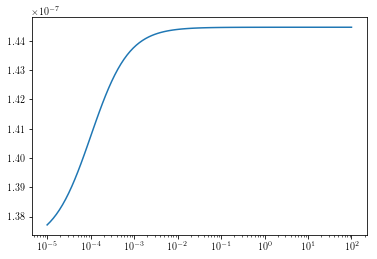

In [54]:
som = np.geomspace(sp_min,sp_max,num)
#plt.plot(som,JPROX)
#plt.plot(som,JDIST)
#plt.plot(som,JPARA)
#plt.plot(som,Jt)
plt.plot(som,IF)
plt.xscale('log')

#### Here I play with different ways of introducing power stroke

In [62]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2;#1e2 
rt_min = 1e-2; rt_max = 1e2;#1e4
num = 100; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; FUEL.append(F0) #lists to renew each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num2):
            
            glf = somma/(r+1)
            ylf = glf
            ylc = glf*r #sm defined accordingly o r and sp in the loop
            glc = ylc
            
 #          ylc = r*somma/(r+1)
 #          glc = ylc
 #          glf = ylc/r
 #          ylf = glf
                    
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp

#            hlp = hp 
            hlm = hm 
            ulp = up 
#            ulm = um 


            hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
#            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
#            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))
            ulm = sqrt((ulp*wlm*ylf*ulp*wlm*glf)/(wlp*glc*wlp*ylc))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
            
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


In [63]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

plt.tight_layout()

shuttlingJ.savefig('Ben_ados/images/dF_cW_J.png', dpi=150)

plt.show()

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


In [64]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingEff3, axSE = plt.subplots(1, figsize=(15,10), sharex=True)

im = axSE.contourf(x,y,np.array(FUELINGEff).reshape(len(y),len(x),order='F'),20, cmap='cividis')
axSE.set_xscale('log')
axSE.set_yscale('log')
axSE.tick_params(axis='x', labelsize=30)
axSE.tick_params(axis='y', labelsize=30)
axSE.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axSE.xaxis.set_label_coords(0.5,-0.075)
axSE.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axSE.yaxis.set_label_coords(-0.075,0.5)
#axSE.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axSE.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axSE.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)



axSE.contour(x,y,np.array(INFOFLOW).reshape(len(y),len(x),order='F'),[0.0],linewidths=3.0,linestyles='--' ,colors='w')

#### ADD THE LINE WHICH MAXIMIZES SOME FUNCTION
#FUNCTION = np.array(FUELINGJ).reshape(len(y),len(x),order='F')
#qfwfq = np.argmax(FUNCTION,axis=0)
#t_0 = []
#for j in range(0,len(qfwfq)):
#    t_0.append(y[qfwfq[j]])
#axSE.plot(x,t_0,c='orange',linewidth='3')
####
axSE.axhline(y=1, c='orange', linestyle='--',linewidth=3.0) 
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')

#plt.text(0.5, 1.5, '$T\dot{\mathcal{I}}<0$',size=30, color='w')
#plt.text(0.5, 0.5, '$T\dot{\mathcal{I}}>0$',size=30, color='w')
#plt.text(0.02, 1.5, '$\dot{\mathcal{E}}>0$',size=30, color='orange')
#plt.text(0.02, 0.5, '$\dot{\mathcal{E}}<0$',size=30, color='orange')


cbar = shuttlingEff3.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.formatter.set_powerlimits((0, 0)) #enforce scientific notation
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Efficiency}, \, \eta$", size=35, labelpad= 5)

plt.tight_layout()


shuttlingEff3.savefig('Ben_ados/images/dF_cW_eff.png', dpi=150)


plt.show()

## Going back to fixing a parameter

In [68]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; ERATCHET = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 1e2;#1e2 
rt_min = 1e-2; rt_max = 1e2;#1e4
num = 100; num2 = 400

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; ER = []; FUEL.append(F0) #lists to renew each cycles and collection of fuel values
    for ylc in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num2):
            
            #glf = somma/(r+1)
            #ylf = glf
            #ylc = glf*r #sm defined accordingly o r and sp in the loop
            #glc = ylc
  
            #ylc = r*somma/(r+1)
            glc = ylc
            glf = ylc/r
            ylf = glf
                    
            flp = fp 
            flm = fm 
            wlm = wm 
            wlp = wp

#           hlp = hp 
            hlm = hm 
#            ulp = up 
            ulm = um 


            hlp = sqrt((hlm*flp*glc*hlm*flp*ylc)/(flm*ylf*flm*glf))
#            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))
#            ulm = sqrt((ulp*wlm*ylf*ulp*wlm*glf)/(wlp*glc*wlp*ylc))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #energy ratchet
            er = jss*log((ylc*glc)/(glf*ylf))
            ER.append(er)
            
            #efficiency
            ncd = R*T*(imh+er)/wch 
            #if imh >= 0 and er <  0: ncd = R*T*(imh)/(wch-R*T*er) 
            #if imh < 0  and er >= 0: ncd = R*T*(er)/(wch-R*T*imh)  
            Eff.append(ncd)
            
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))
    ERATCHET.append(np.array(ER))


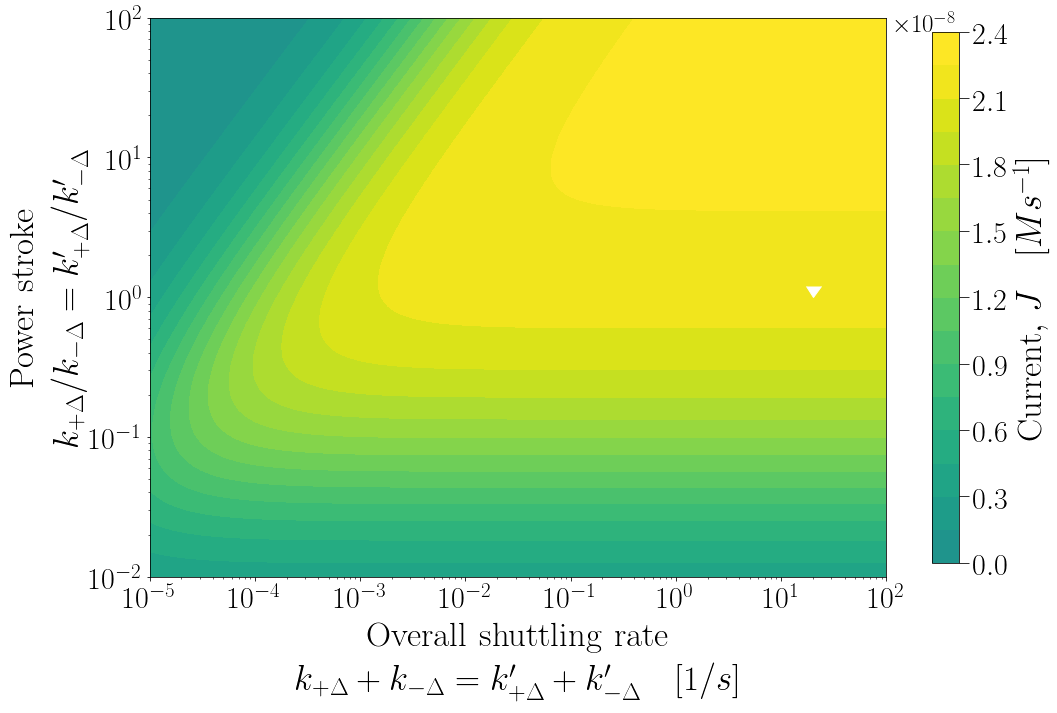

In [69]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num2))

shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

#elev_min= -2e-7
#elev_max= 6e-7
elev_min= min(FUELINGJ[0])
elev_max=max(FUELINGJ[0])
mid_val=0.0

im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
#im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20)
axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{+\Delta} + k'_{-\Delta} \quad [1/s]$",linespacing=1.5 ,size=35)
axS.xaxis.set_label_coords(0.5,-0.075)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=30)
axS.tick_params(axis='y', labelsize=30)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n ${k_{+\Delta}}/{k_{-\Delta}} = {k'_{+\Delta}}/{k'_{-\Delta}}$",linespacing=1.5 ,size=35)
axS.yaxis.set_label_coords(-0.075,0.5)
#axS.set_title('$[\mathrm{F}] = %s \; M$'%FUEL, size=25, pad=10.0)
#axS.axhline(y=yc/gf, c='0.5', linestyle=':',linewidth=2.0) 
#axS.axvline(x=yc+gf, c='0.5', linestyle=':',linewidth=2.0)
plt.plot(yc+gf,yc/gf, marker=7,markersize=15,c='w')


cbar = shuttlingJ.colorbar(im, shrink=0.95)
cbar.ax.tick_params(labelsize=30, length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(25)
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=35, labelpad= 5)

plt.tight_layout()

#shuttlingJ.savefig('Ben_ados/images/dF_cW_J.png', dpi=150)

#plt.show()